In [ ]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

# Use the actual notebook working directory
nb_dir = Path.cwd()
print(f"Current notebook path: {nb_dir}")

# Optionally add the notebook dir (for local-only imports)
if str(nb_dir) not in sys.path:
    sys.path.insert(0, str(nb_dir))
    print(f"Added {nb_dir} to sys.path")

# Critically: add the repository root so top-level packages like 'utils' are importable
# Notebook path: /home/luky/skola/KalmanNet-main/navigation NCLT dataset/linear_velocity_integration
# Repo root is two levels up: /home/luky/skola/KalmanNet-main
repo_root = nb_dir.parents[1]
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
    print(f"Added {repo_root} to sys.path")

In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


Načítám data z: ../preprocessed_NCLT_trajectory-2012-01-22-angle-update...
✅ Data úspěšně načtena.
  -> Celkový počet vzorků: 5208
  -> Input Shape (Měření): torch.Size([5208, 4]) ... [GPS_X, ODO_VX, GPS_Y, ODO_VY]
  -> Target Shape (GT):    torch.Size([5208, 4]) ... [PX, VX, PY, VY]


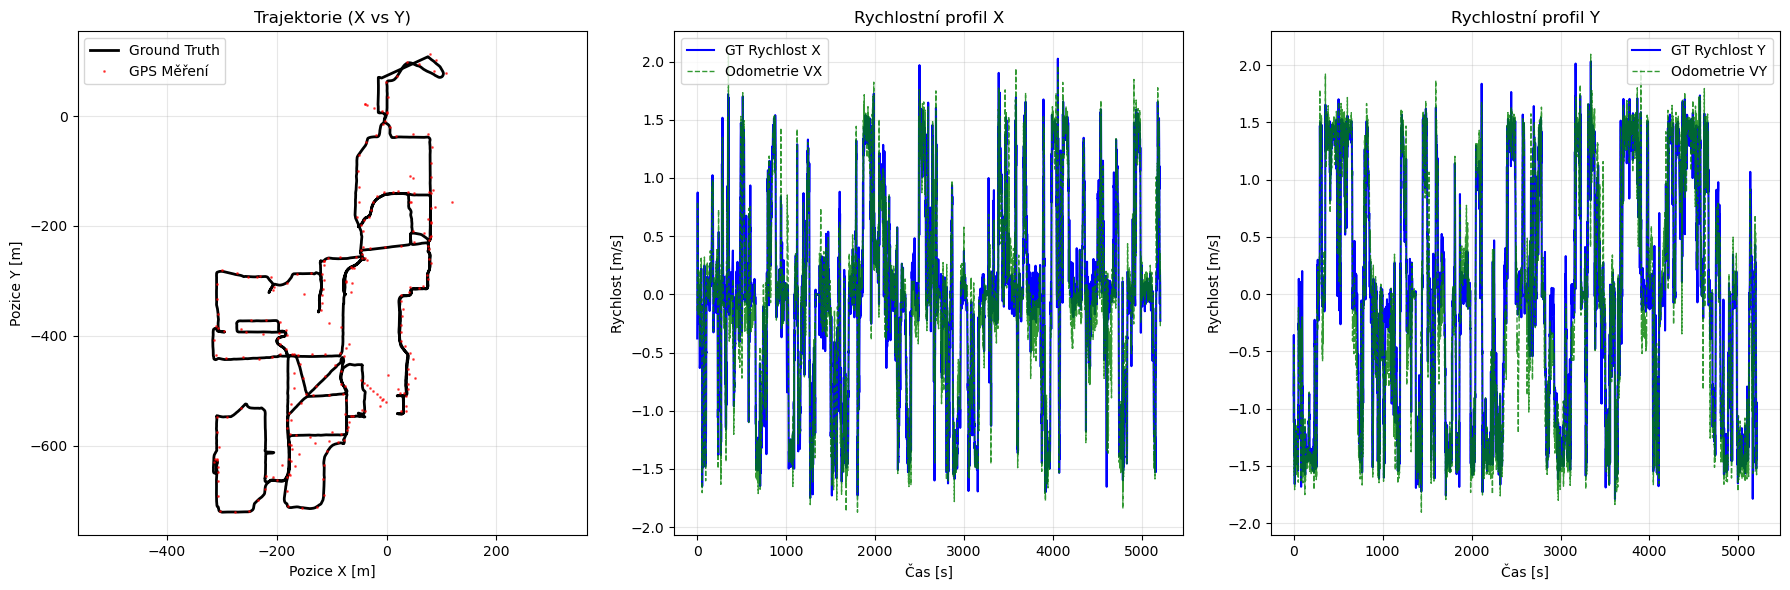

In [3]:
import torch
import matplotlib.pyplot as plt
import os
import numpy as np

# === 1. KONFIGURACE ===
# Cesta k adresáři, který vytvořil preprocess skript
data_dir = '../preprocessed_NCLT_trajectory-2012-01-22-angle-update'

print(f"Načítám data z: {data_dir}...")

try:
    # === 2. NAČTENÍ DAT (.pt soubory) ===
    # Data jsou uložena jako list slovníků [{'ground_truth': ..., 'filtered_gps': ...}]
    # filtered_gps zde ale obsahuje náš 4D vektor [GPS_X, ODO_VX, GPS_Y, ODO_VY]
    
    train_data = torch.load(os.path.join(data_dir, 'train.pt'))
    val_data = torch.load(os.path.join(data_dir, 'val.pt'))
    test_data = torch.load(os.path.join(data_dir, 'test.pt'))

    # Extrakce tensorů (předpokládáme 1 trajektorii v listu)
    X_train, Y_train = train_data[0]['ground_truth'], train_data[0]['filtered_gps']
    X_val, Y_val     = val_data[0]['ground_truth'],   val_data[0]['filtered_gps']
    X_test, Y_test   = test_data[0]['ground_truth'],  test_data[0]['filtered_gps']

    # Spojení zpět do jedné sekvence pro vizualizaci celé trajektorie
    X_full = torch.cat([X_train, X_val, X_test], dim=0)
    Y_full = torch.cat([Y_train, Y_val, Y_test], dim=0)

    print(f"✅ Data úspěšně načtena.")
    print(f"  -> Celkový počet vzorků: {X_full.shape[0]}")
    print(f"  -> Input Shape (Měření): {Y_full.shape} ... [GPS_X, ODO_VX, GPS_Y, ODO_VY]")
    print(f"  -> Target Shape (GT):    {X_full.shape} ... [PX, VX, PY, VY]")

    # === 3. VIZUALIZACE ===
    # Převedeme na numpy pro matplotlib
    gt_np = X_full.numpy()
    meas_np = Y_full.numpy()
    time_steps = np.arange(len(gt_np)) # Předpoklad 1Hz (DT=1.0)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # --- A) Trajektorie (X-Y) ---
    # Ground Truth (Sloupce 0 a 2 v Targetu)
    ax[0].plot(gt_np[:, 0], gt_np[:, 2], 'k-', linewidth=2, label='Ground Truth')
    
    # GPS Měření (Sloupce 0 a 2 v Inputu)
    # Vykreslíme jen každý 20. bod, aby graf nebyl přeplácaný
    ax[0].plot(meas_np[::20, 0], meas_np[::20, 2], 'r.', markersize=2, alpha=0.6, label='GPS Měření')

    ax[0].set_title('Trajektorie (X vs Y)')
    ax[0].set_xlabel('Pozice X [m]')
    ax[0].set_ylabel('Pozice Y [m]')
    ax[0].axis('equal')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # --- B) Rychlost X (VX) ---
    # GT Rychlost (Sloupec 1 v Targetu)
    ax[1].plot(time_steps, gt_np[:, 1], 'b-', linewidth=1.5, label='GT Rychlost X')
    # ODO Rychlost (Sloupec 1 v Inputu)
    ax[1].plot(time_steps, meas_np[:, 1], 'g--', linewidth=1, alpha=0.8, label='Odometrie VX')

    ax[1].set_title('Rychlostní profil X')
    ax[1].set_xlabel('Čas [s]')
    ax[1].set_ylabel('Rychlost [m/s]')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    # --- C) Rychlost Y (VY) ---
    # GT Rychlost (Sloupec 3 v Targetu)
    ax[2].plot(time_steps, gt_np[:, 3], 'b-', linewidth=1.5, label='GT Rychlost Y')
    # ODO Rychlost (Sloupec 3 v Inputu)
    ax[2].plot(time_steps, meas_np[:, 3], 'g--', linewidth=1, alpha=0.8, label='Odometrie VY')

    ax[2].set_title('Rychlostní profil Y')
    ax[2].set_xlabel('Čas [s]')
    ax[2].set_ylabel('Rychlost [m/s]')
    ax[2].legend()
    ax[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"❌ CHYBA: Adresář '{data_dir}' nebo soubory .pt nenalezeny.")
    print("Spustil jsi předtím skript 'preprocess_NCLT_trajectory_linear_test.py'?")
except Exception as e:
    print(f"❌ CHYBA: {e}")

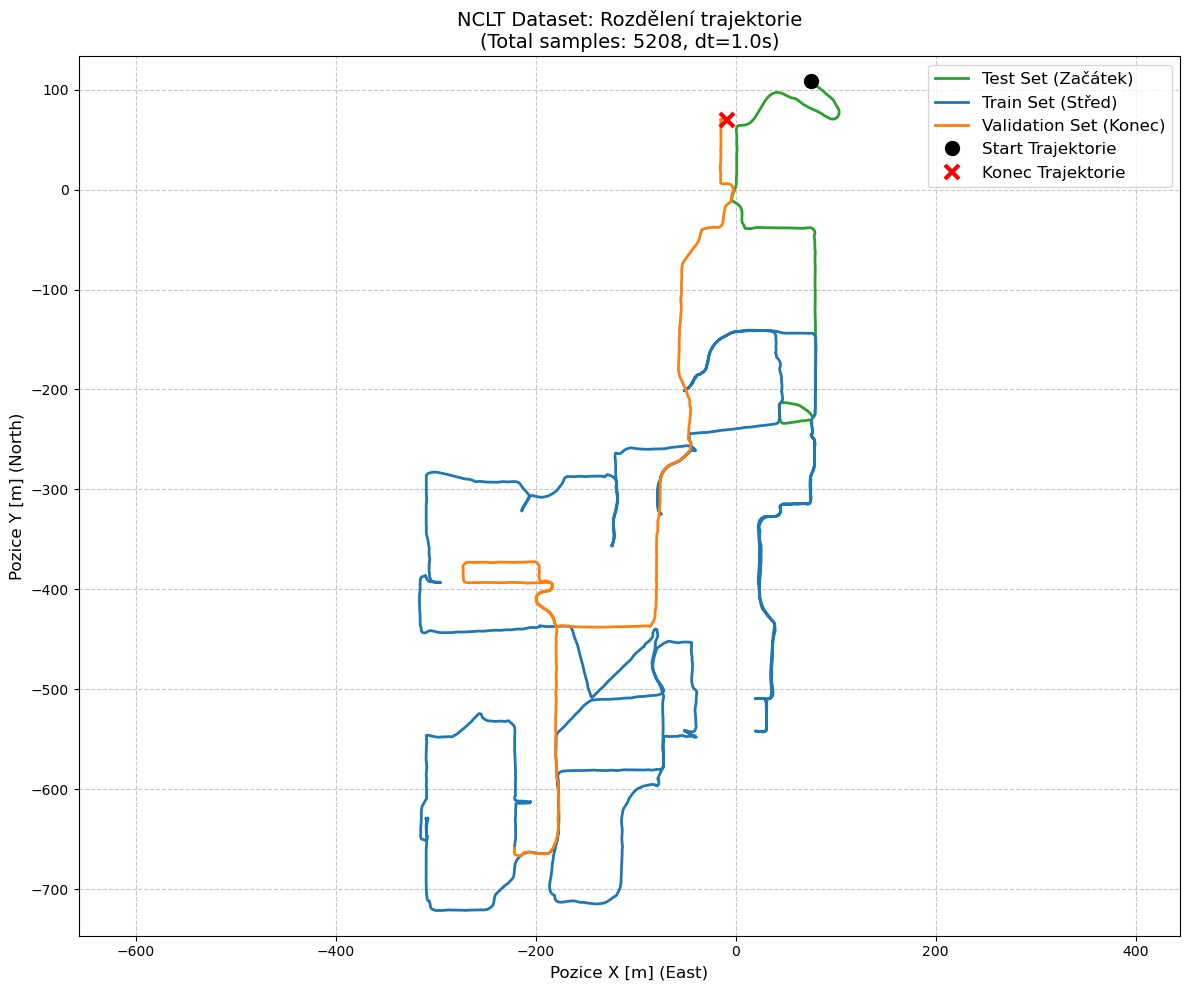

In [4]:
import matplotlib.pyplot as plt

# === VIZUALIZACE ROZDĚLENÍ DATASETU ===

plt.figure(figsize=(12, 10))

# Používáme proměnné z předchozího kroku: X_train, X_val, X_test
# Konverze .numpy() funguje, pokud jsou tensory na CPU (což po načtení torch.load obvykle jsou)

# 1. Testovací část (Podle tvého 'save_splits' je Test na začátku - prvních cca 10%)
plt.plot(X_test[:, 0].numpy(), 
         X_test[:, 2].numpy(), 
         label='Test Set (Začátek)', color='#2ca02c', linewidth=2) # Zelená

# 2. Trénovací část (Navazuje na Test - středních 70%)
plt.plot(X_train[:, 0].numpy(), 
         X_train[:, 2].numpy(), 
         label='Train Set (Střed)', color='#1f77b4', linewidth=2) # Modrá

# 3. Validační část (Navazuje na Train - koncových 20%)
plt.plot(X_val[:, 0].numpy(), 
         X_val[:, 2].numpy(), 
         label='Validation Set (Konec)', color='#ff7f0e', linewidth=2) # Oranžová

# Zvýraznění začátku a konce celé trajektorie
# Začátek je v prvním bodě Testovací sady
plt.plot(X_test[0, 0], X_test[0, 2], 'ko', markersize=10, label='Start Trajektorie')

# Konec je v posledním bodě Validační sady
plt.plot(X_val[-1, 0], X_val[-1, 2], 'rx', markersize=10, markeredgewidth=3, label='Konec Trajektorie')

# Formátování grafu
# N_samples a DT vezmeme z kontextu předchozího cellu nebo definujeme
N_samples = X_full.shape[0] 
DT = 1.0 

plt.title(f'NCLT Dataset: Rozdělení trajektorie\n(Total samples: {N_samples}, dt={DT}s)', fontsize=14)
plt.xlabel('Pozice X [m] (East)', fontsize=12)
plt.ylabel('Pozice Y [m] (North)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')  # Důležité: Aby mapa nebyla deformovaná

plt.tight_layout()
plt.show()

# Model definition

In [5]:
import torch
import math
import Systems 

# Nastavení zařízení
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#########################
### Design Parameters ###
### (OPTIMALIZOVANÉ)  ###
#########################

# 1. Rozměry
# Stav: [px, vx, py, vy]
m = 4 
n = 4 
delta_t = 1.0 

# 2. Dynamika (F)
# x_{t+1} = x_t + v_t * dt
F_dim = torch.tensor([[1.0, delta_t],
                      [0.0, 1.0]])

F_design = torch.block_diag(F_dim, F_dim).float()

# 3. Měření (H)
H_design = torch.eye(n).float()

# ==========================================
# 4. Šum procesu (Q) - OPTIMALIZOVÁNO
# ==========================================
# Hodnota z Optuny (MSE ~760)
# q_scale = 0.00006806
# q_scale = 0.00013203

# grid search:
q_scale = 0.00012224

# Používáme kinematický model (Discrete White Noise Acceleration), 
# který byl použit v optimalizačním skriptu.
# Blok pro jednu dimenzi (pozice + rychlost):
Q_block_val = torch.tensor([
    [(delta_t**3)/3, (delta_t**2)/2],
    [(delta_t**2)/2,  delta_t      ]
]) * q_scale

# Výsledná Q pro [px, vx, py, vy]
Q_design = torch.block_diag(Q_block_val, Q_block_val).float()


# ==========================================
# 5. Šum měření (R) - OPTIMALIZOVÁNO
# ==========================================
# Hodnoty z Optuny
# var_gps = 38.370833  # Vysoká nedůvěra v GPS (odpovídá realitě NCLT)
# var_odo = 0.000560   # Extrémní důvěra v Odometrii
# var_gps = 39.321669
# var_odo = 0.00057
#grid search:
var_gps = 39.275433
var_odo = 0.000566


# Pořadí stavů: [Pos_X, Vel_X, Pos_Y, Vel_Y]
# Takže střídáme: [GPS, ODO, GPS, ODO]
R_design = torch.tensor([
    [var_gps, 0.0,     0.0,     0.0],
    [0.0,     var_odo, 0.0,     0.0],
    [0.0,     0.0,     var_gps, 0.0],
    [0.0,     0.0,     0.0,     var_odo]
]).float()

# 6. Počáteční podmínky
m1x_0 = torch.zeros(m, 1).float()
m2x_0 = torch.diag(torch.tensor([10.0, 1.0, 10.0, 1.0])) # Velká nejistota v pozici, menší v rychlosti

print("\nInicializuji systém dle OPTIMALIZOVANÝCH parametrů (NCLT)...")
print(f"Dimenze stavu: {m}, Dimenze měření: {n}")
print(f"Q scale: {q_scale}")
print(f"R diagonal: {torch.diagonal(R_design)}")

# === INICIALIZACE SYSTÉMŮ ===

sys_true = Systems.DynamicSystem(
    state_dim=m, obs_dim=n,
    Ex0=m1x_0, P0=m2x_0,
    Q=Q_design, R=R_design,
    F=F_design, H=H_design,
    device=device
)

sys_model = Systems.DynamicSystem(
    state_dim=m, obs_dim=n,
    Ex0=m1x_0, P0=m2x_0,
    Q=Q_design, R=R_design,
    F=F_design, H=H_design,
    device=device
)

print("... Systémy inicializovány.")
print("POZOR: Tento model očekává pořadí stavů [px, vx, py, vy].")


Inicializuji systém dle OPTIMALIZOVANÝCH parametrů (NCLT)...
Dimenze stavu: 4, Dimenze měření: 4
Q scale: 0.00012224
R diagonal: tensor([3.9275e+01, 5.6600e-04, 3.9275e+01, 5.6600e-04])
... Systémy inicializovány.
POZOR: Tento model očekává pořadí stavů [px, vx, py, vy].


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# === 1. KONFIGURACE ===
# Dynamicky zjistíme délku testovací sady z proměnné X_test (kterou máme z minula)
# Pokud by X_test neexistovalo, kód spadne, ale to by znamenalo, že jsi nenačetl data.
TEST_SEQ_LEN = X_test.shape[0] 

TRAIN_SEQ_LEN = 50    # Délka sekvence pro trénink (krátká okna)
VAL_SEQ_LEN = 200     # Validace po delších úsecích
STRIDE = 10           # Posun okna (překryv)
BATCH_SIZE = 128      # Velikost dávky

def create_sequences(X, Y, seq_len, stride=1):
    """
    Rozseká dlouhé tenzory [Total_Len, Dim] na sekvence [N_seq, Seq_Len, Dim].
    """
    xs = []
    ys = []
    num_samples = X.shape[0]
    
    # Pokud je seq_len větší než data (např. u testu), vezmeme prostě to, co máme
    if seq_len > num_samples:
        seq_len = num_samples
    
    for i in range(0, num_samples - seq_len + 1, stride):
        x_seq = X[i : i+seq_len, :]
        y_seq = Y[i : i+seq_len, :]
        xs.append(x_seq)
        ys.append(y_seq)
        
    if len(xs) == 0:
        # Fallback: Pokud by data byla kratší než seq_len, vrátíme prázdné nebo 1 kus
        return X.unsqueeze(0), Y.unsqueeze(0)
        
    return torch.stack(xs), torch.stack(ys)

def clean_sequences(X_seq, Y_seq, name="Dataset"):
    """
    Filtruje sekvence, které obsahují jakékoliv NaN nebo Inf hodnoty.
    """
    if X_seq.numel() == 0:
        print(f"⚠️ {name}: Prázdný vstup!")
        return X_seq, Y_seq

    # Zkontrolujeme NaN/Inf pro každou sekvenci zvlášť
    is_nan_x = torch.isnan(X_seq).reshape(X_seq.shape[0], -1).any(dim=1)
    is_inf_x = torch.isinf(X_seq).reshape(X_seq.shape[0], -1).any(dim=1)
    
    is_nan_y = torch.isnan(Y_seq).reshape(Y_seq.shape[0], -1).any(dim=1)
    is_inf_y = torch.isinf(Y_seq).reshape(Y_seq.shape[0], -1).any(dim=1)
    
    invalid_mask = is_nan_x | is_inf_x | is_nan_y | is_inf_y
    valid_mask = ~invalid_mask
    
    X_clean = X_seq[valid_mask]
    Y_clean = Y_seq[valid_mask]
    
    n_dropped = invalid_mask.sum().item()
    if n_dropped > 0:
        print(f"⚠️ {name}: Odstraněno {n_dropped} vadných sekvencí (NaN/Inf). Zbývá: {len(X_clean)}")
    else:
        print(f"✅ {name}: Data jsou čistá. ({len(X_clean)} sekvencí)")
        
    return X_clean, Y_clean

print("--- ZPRACOVÁNÍ DAT ---")

# === 2. TVORBA SEKVENCÍ A PŘETYPOVÁNÍ ===
# OPRAVA PROMĚNNÝCH: Používáme X_train, Y_train atd. místo train_target/input
# X = Ground Truth, Y = Měření (Input)
print(f"Generuji sekvence (Test délka: {TEST_SEQ_LEN})...")

# Train: Krátká okna s překryvem
train_X_raw, train_Y_raw = create_sequences(X_train.float(), Y_train.float(), TRAIN_SEQ_LEN, STRIDE)

# Val: Delší okna (bez překryvu)
val_X_raw, val_Y_raw = create_sequences(X_val.float(), Y_val.float(), VAL_SEQ_LEN, VAL_SEQ_LEN)

# Test: Jedna dlouhá sekvence (pro kontinuální vyhodnocení)
# Stride = TEST_SEQ_LEN zajistí, že dostaneme právě jeden (nebo málo) dlouhých kusů
test_X_raw, test_Y_raw = create_sequences(X_test.float(), Y_test.float(), TEST_SEQ_LEN, TEST_SEQ_LEN)

# === 3. ČIŠTĚNÍ DAT (NAN/INF FILTER) ===
print("\nFiltruji NaN hodnoty...")
train_X_seq, train_Y_seq = clean_sequences(train_X_raw, train_Y_raw, "Train")
val_X_seq, val_Y_seq = clean_sequences(val_X_raw, val_Y_raw, "Val")
test_X_seq, test_Y_seq = clean_sequences(test_X_raw, test_Y_raw, "Test")

# === 4. VYTVOŘENÍ DATALOADERŮ ===
print("\nVytvářím DataLoadery...")
# Train: Shuffle=True (Důležité pro trénink)
train_dataset = TensorDataset(train_X_seq, train_Y_seq)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Val/Test: Shuffle=False (Abychom viděli průběh)
val_dataset = TensorDataset(val_X_seq, val_Y_seq)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(test_X_seq, test_Y_seq)
# Pro test batch_size=1, protože máme jednu obří sekvenci (nebo pár velkých)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"\n✅ HOTOVO. Připraveno k tréninku.")
print(f"Train batches: {len(train_loader)} (Batch shape: {next(iter(train_loader))[0].shape})")
print(f"Test batches:  {len(test_loader)} (Seq len: {test_X_seq.shape[1]})")

--- ZPRACOVÁNÍ DAT ---
Generuji sekvence (Test délka: 522)...

Filtruji NaN hodnoty...
✅ Train: Data jsou čistá. (360 sekvencí)
✅ Val: Data jsou čistá. (5 sekvencí)
✅ Test: Data jsou čistá. (1 sekvencí)

Vytvářím DataLoadery...

✅ HOTOVO. Připraveno k tréninku.
Train batches: 3 (Batch shape: torch.Size([128, 50, 4]))
Test batches:  1 (Seq len: 522)


In [7]:
import torch
import torch.optim as optim
import os
from state_NN_models import StateBayesianKalmanNet,StateKalmanNet
from utils import trainer

state_bkn = StateBayesianKalmanNet(sys_model, device=device, hidden_size_multiplier=10,
                                   output_layer_multiplier=4,num_gru_layers=1,
                                    init_max_dropout=0.3,init_min_dropout=0.1, norm_states=True).to(device)

print(state_bkn)


state_knet = state_knet = StateKalmanNet(sys_model, device=device, hidden_size_multiplier=8,
                                         output_layer_multiplier=4,num_gru_layers=1,
                                         gru_hidden_dim_multiplier=4,
                                         returns_covariance=True).to(device)
print(state_knet)


INFO: Aplikuji 'Start Zero' inicializaci pro Kalman Gain.
DEBUG: Výstupní vrstva vynulována (Soft Start).
StateBayesianKalmanNet(
  (dnn): DNN_BayesianKalmanNet(
    (input_layer): Sequential(
      (0): Linear(in_features=16, out_features=640, bias=True)
      (1): ReLU()
    )
    (concrete_dropout1): ConcreteDropout()
    (gru): GRU(640, 128)
    (output_layer): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=16, bias=True)
    )
    (concrete_dropout2): ConcreteDropout()
  )
)
DEBUG: Layer 'output_final_linear.0' initialized near zero (Start K=0).
StateKalmanNet(
  (dnn): DNN_KalmanNet(
    (input_layer): Sequential(
      (0): Linear(in_features=16, out_features=512, bias=True)
      (1): ReLU()
    )
    (gru): GRU(512, 128)
    (output_hidden_layer): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (output_final_linear): Sequential(
  

In [8]:
import os
import torch

# ==========================================
# 1. NASTAVENÍ NÁZVŮ SOUBORŮ (Manuální vstup)
# ==========================================
# Složka, kde jsou váhy uloženy
WEIGHTS_DIR = 'NN_weights'

# Zde doplň přesné názvy souborů .pth
# KNET_FILENAME = 'best_Knet_test_results.pth'                                          # Příklad
KNET_FILENAME = 'KalmanNet_test.pth' #best_MSE_KalmanNet_linear_trajectory
BKN_FILENAME = 'best_MSE_BayesianKalmanNet_linear_trajectory-MSE2.3662|ANEES7.9216.pth'  

# ==========================================
# 2. FUNKCE PRO BEZPEČNÉ NAČTENÍ
# ==========================================
def load_pretrained_weights(model, filename, model_name):
    filepath = os.path.join(WEIGHTS_DIR, filename)
    
    if not os.path.exists(filepath):
        print(f"⚠️  VAROVÁNÍ: Soubor '{filename}' pro {model_name} nebyl nalezen v '{WEIGHTS_DIR}'.")
        return

    try:
        # Načtení na správné zařízení (CPU/GPU)
        checkpoint = torch.load(filepath, map_location=device)
        
        # Detekce, zda jde o čistý state_dict nebo slovník checkpointu
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            # Pokud je to checkpoint z traineru, vytáhneme jen váhy modelu
            state_dict = checkpoint['model_state_dict']
        elif isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            # Předpokládáme, že je to přímo state_dict
            state_dict = checkpoint

        # Nahrání vah do modelu
        model.load_state_dict(state_dict)
        
        # Důležité: Přepnutí do evaluačního módu (vypne Dropout, fixuje BatchNorm)
        model.eval()
        
        print(f"✅ {model_name}: Váhy úspěšně načteny z '{filename}'.")
        
    except Exception as e:
        print(f"❌ CHYBA: Nepodařilo se načíst váhy pro {model_name}.\n   Důvod: {e}")

# ==========================================
# 3. SPUŠTĚNÍ NAČÍTÁNÍ
# ==========================================
print(f"--- Načítání vah ze složky: {os.path.abspath(WEIGHTS_DIR)} ---\n")

# Načtení State KalmanNet
load_pretrained_weights(state_knet, KNET_FILENAME, "State KalmanNet")

# Načtení Bayesian KalmanNet
load_pretrained_weights(state_bkn, BKN_FILENAME, "State BKN")

print("\n--- Hotovo ---")

--- Načítání vah ze složky: /home/luky/skola/KalmanNet-main/navigation NCLT dataset/NCLT_linear_model_test/NN_weights ---

✅ State KalmanNet: Váhy úspěšně načteny z 'KalmanNet_test.pth'.
✅ State BKN: Váhy úspěšně načteny z 'best_MSE_BayesianKalmanNet_linear_trajectory-MSE2.3662|ANEES7.9216.pth'.

--- Hotovo ---


In [9]:
import torch
import numpy as np
from MDM.MDM_functions import MDM_nullO_LTI, pinv, Ksi_fun, baseMatrix_fun, Upsilon_2_fun, kron2_vec, kron2_mat

from tqdm import tqdm

class KalmanFilter:
    """
    Kalmanův filtr pro t-invaritantní systém s lineární dynamikou.
    (Původní implementace beze změn)
    """
    def __init__(self,model):
        self.device = model.Q.device
        self.model = model
        self.Ex0 = model.Ex0
        self.P0 = model.P0
        self.F = model.F
        self.H = model.H
        self.Q = model.Q
        self.R = model.R
        self.state_dim = self.F.shape[0]
        self.obs_dim = self.H.shape[0]

        # Interní stav pro online použití
        self.x_predict_current = None
        self.P_predict_current = None
        self.reset(model.Ex0, model.P0)

    def reset(self, Ex0, P0):
        self.x_predict_current = Ex0.clone().detach().reshape(self.state_dim, 1)
        self.P_predict_current = P0.clone().detach()

    def predict_step(self, x_filtered, P_filtered):
        x_predict = self.F @ x_filtered
        P_predict = self.F @ P_filtered @ self.F.T + self.Q
        return x_predict, P_predict

    def update_step(self, x_predict, y_t, P_predict):
        y_t = y_t.reshape(self.obs_dim, 1)
        innovation = self.compute_innovation(y_t, x_predict)
        K = self.compute_kalman_gain(P_predict)
        x_filtered = x_predict + K @ innovation
        I = torch.eye(self.state_dim, device=self.device)
        P_filtered = (I - K @ self.H) @ P_predict @ (I - K @ self.H).T + K @ self.R @ K.T 
        return x_filtered, P_filtered, K, innovation

    def compute_kalman_gain(self, P_predict):
        return P_predict @ self.H.T @ torch.linalg.inv(self.H @ P_predict @ self.H.T + self.R)
    
    def compute_innovation(self, y_t, x_predict):
        return y_t - self.H @ x_predict
    
    def step(self, y_t):
        x_filtered, P_filtered, _, _ = self.update_step(self.x_predict_current, y_t, self.P_predict_current)
        x_predict_next, P_predict_next = self.predict_step(x_filtered, P_filtered)
        self.x_predict_current = x_predict_next
        self.P_predict_current = P_predict_next
        return x_filtered, P_filtered

    def process_sequence(self, y_seq, Ex0=None, P0=None):
            seq_len = y_seq.shape[0]
            x_filtered_history = torch.zeros(seq_len, self.state_dim, device=self.device)
            P_filtered_history = torch.zeros(seq_len, self.state_dim, self.state_dim, device=self.device)
            kalman_gain_history = torch.zeros(seq_len, self.state_dim, self.obs_dim, device=self.device)
            innovation_history = torch.zeros(seq_len, self.obs_dim, device=self.device)

            if Ex0 is None: Ex0 = self.Ex0
            if P0 is None: P0 = self.P0
            x_predict_k = Ex0.clone().detach().reshape(self.state_dim, 1)
            P_predict_k = P0.clone().detach()
            
            for k in range(seq_len):
                x_filtered, P_filtered, K, innovation = self.update_step(x_predict_k, y_seq[k], P_predict_k)
                x_predict_k_plus_1, P_predict_k_plus_1 = self.predict_step(x_filtered, P_filtered)
                x_predict_k = x_predict_k_plus_1
                P_predict_k = P_predict_k_plus_1
                x_filtered_history[k] = x_filtered.squeeze()
                P_filtered_history[k] = P_filtered
                kalman_gain_history[k] = K
                innovation_history[k] = innovation.squeeze()

            return {
                'x_filtered': x_filtered_history,
                'P_filtered': P_filtered_history,
                'Kalman_gain': kalman_gain_history,
                'innovation': innovation_history
            }

class AdaptiveKalmanFilter_online:
    def __init__(self, model, mdm_L=4, mdm_version=1, lambda_rls=0.995, q_init=1e-3, init_sigma_rls_value=10.0, alpha_nom=None):
        """
        Adaptivní KF (Semi-weighted Recursive verze - Sw-Re).
        Tato třída provádí online identifikaci matic Q a R.
        """
        self.kf = KalmanFilter(model)
        self.device = model.Q.device
        
        self.mdm_L = mdm_L
        self.mdm_version = mdm_version
        self.lambda_rls = lambda_rls
        self.q_init_val = q_init
        self.init_sigma_val = init_sigma_rls_value
        self.alpha_nom_val = alpha_nom
        self.nw = self.kf.F.shape[0] # Dimenze stavového šumu (W)
        self.nv = self.kf.H.shape[0] # Dimenze šumu měření (V)
        
        self.T = T = 1.0
        T2 = (T**2) / 2.0
        T3 = (T**3) / 3.0
        
        self.Q_template = np.array([
            [T3, T2, 0,  0],
            [T2, T,  0,  0],
            [0,  0,  T3, T2],
            [0,  0,  T2, T]
        ])
        self.vec_Q_template = self.Q_template[np.triu_indices(self.nw)][:, np.newaxis]
        self.n_params_Q_full = (self.nw * (self.nw + 1)) // 2 
        self.n_params_R_full = (self.nv * (self.nv + 1)) // 2
        self.n_params_R_reduced = 2
        
        self.T_R_matrix = np.zeros((self.n_params_R_full, self.n_params_R_reduced))
        self.T_R_matrix[0, 0] = 1.0 
        self.T_R_matrix[7, 0] = 1.0 
        self.T_R_matrix[4, 1] = 1.0 
        self.T_R_matrix[9, 1] = 1.0 
        
        # 3. INICIALIZACE RLS
        self.n_params = 1 + self.n_params_R_reduced

        self.q_init = self.q_init_val
        
        R0 = model.R.cpu().numpy()
        r1_init = R0[0,0]
        r2_init = R0[1,1]
        
        self.alpha_est = np.array([self.q_init, r1_init, r2_init], dtype=np.float64)
        
        # BEZPEČNÉ NAČTENÍ alpha_nom (Zůstáváme u 1D pole)
        if self.alpha_nom_val is not None:
            self.alpha_nom = np.array(self.alpha_nom_val, dtype=np.float64)
        else:
            self.alpha_nom = np.copy(self.alpha_est)

        # P_RLS
        sigma_q  = (self.alpha_nom[0] * self.init_sigma_val)**2 + 1e-12
        sigma_r1 = (self.alpha_nom[1] * self.init_sigma_val)**2 + 1e-12
        sigma_r2 = (self.alpha_nom[2] * self.init_sigma_val)**2 + 1e-12
        self.Sigma_RLS = np.diag([sigma_q, sigma_r1, sigma_r2])
        # Buffery
        self.z_buffer = []
        self.u_buffer = []
        self.Upsilon_2 = None

    def _get_upsilon(self):
        """
        Pomocná funkce pro získání matice Upsilon.
        Tato matice je čistě strukturální (záleží jen na dimenzích) a slouží
        k manipulaci s Kroneckerovými součiny v rámci MDM teorie.
        Počítá se jen jednou.
        """
        if self.Upsilon_2 is None:
            w2b = [baseMatrix_fun(self.nw, 1)] 
            v2b = [baseMatrix_fun(self.nv, 1)] 
            self.Upsilon_2 = Upsilon_2_fun(w2b, v2b, self.mdm_L)
        return self.Upsilon_2

    def _reconstruct_qr_from_alpha2(self, alpha_2):
        """
        KLÍČOVÁ FUNKCE: Převod vektoru parametrů zpět na matice.
        
        Vstup: alpha_2 (vektor délky n_params)
        Výstup: Matice Q a R
        
        Logika:
        1. Rozdělí vektor alpha na část pro Q a část pro R.
        2. Vytvoří prázdné matice.
        3. Vyplní horní trojúhelník (triu) hodnotami z vektoru.
        4. Zkopíruje hodnoty i do dolního trojúhelníku (symetrizace),
           protože kovarianční matice musí být symetrická (Q_ij = Q_ji).
        """
        # Kolik prvků patří matici Q?
        q_len = (self.nw * (self.nw + 1)) // 2
        
        # Rozdělení vektoru
        alpha_q = alpha_2[:q_len]
        alpha_r = alpha_2[q_len:]
        
        # Rekonstrukce Q
        Q_est = np.zeros((self.nw, self.nw))
        i, j = np.triu_indices(self.nw)
        # Vyplnění horního trojúhelníku
        Q_est[i, j] = alpha_q
        # Symetrizace: Q[j, i] = Q[i, j]
        # Tímto říkáme, že kovariance mezi stavem 1 a 2 je stejná jako mezi 2 a 1.
        Q_est[j, i] = alpha_q
        
        # Rekonstrukce R (stejný princip)
        R_est = np.zeros((self.nv, self.nv))
        i, j = np.triu_indices(self.nv)
        R_est[i, j] = alpha_r
        R_est[j, i] = alpha_r
        
        return Q_est, R_est

    def step_adaptive(self, y_t, u_t=None):
        """
        Jeden krok adaptivního filtru s UNWEIGHTED RLS.
        """
        # --- 1. Update Bufferu (Posuvné okno) ---
        y_np = y_t.cpu().numpy().squeeze()
        if y_np.ndim == 0: y_np = np.expand_dims(y_np, axis=0)
        
        if u_t is not None:
            u_np = u_t.cpu().numpy().squeeze()
            if u_np.ndim == 0: u_np = np.expand_dims(u_np, axis=0)
        else:
            u_np = np.zeros(1)

        self.z_buffer.append(y_np)
        self.u_buffer.append(u_np)
        
        # Udržování fixní délky okna L (FIFO fronta)
        if len(self.z_buffer) > self.mdm_L:
            self.z_buffer.pop(0)
            self.u_buffer.pop(0)

        # --- 2. Identifikace Q a R (RLS) ---
        # Spustí se pouze, pokud je buffer plný (dost dat pro MDM)
        if len(self.z_buffer) == self.mdm_L:
            try:
                z_window = np.array(self.z_buffer)
                u_window = np.array(self.u_buffer)
                
                # Získání matic systému
                F_np = self.kf.F.cpu().numpy()
                H_np = self.kf.H.cpu().numpy()
                G_np = np.zeros((self.nw, u_window.shape[1])) # matice pro vstup u 
                E_np = np.eye(self.nw) # matice pro šum w
                D_np = np.eye(self.nv) # matice pro šum v
                nz_np = np.array([self.nv])

                # MDM: Výpočet rezidua a regresoru
                # r_k: Vektor reziduí, který nese informaci o šumu v datech
                # Awv_matrix: Pomocná matice popisující dynamiku systému v okně
                r_list, Awv_matrix = MDM_nullO_LTI(
                    self.mdm_L, F_np, G_np, E_np, nz_np, H_np, D_np, 
                    z_window, u_window, self.mdm_version
                )
                r_k = r_list[0]
                
                nr = r_k.shape[0]
                Ksi = Ksi_fun(nr) # Unifikační matice (vybírá unikátní prvky ze symetrické matice)
                
                # Pozorování pro RLS (y_rls):
                # Vychází z vnějšího součinu rezidua (r_k * r_k^T), což je "okamžitá kovariance".
                # kron2_vec to převede na vektor a Ksi vybere unikátní prvky.
                # OPRAVA TADY: Zploštění y_rls
                y_rls = (Ksi @ kron2_vec(r_k)).flatten()
                
                # Regresní matice (H_rls):
                # Popisuje lineární vztah mezi parametry (Q, R) a pozorováním (kovariancí rezidua).
                Upsilon = self._get_upsilon()
                H_full = Ksi @ kron2_mat(Awv_matrix) @ Upsilon

                # 1. Rozdělení na Q část a R část
                H_Q_part_full = H_full[:, :self.n_params_Q_full] 
                H_R_part_full = H_full[:, self.n_params_Q_full:]
                
                # 2. Transformace Q (10 sloupců -> 1 sloupec)
                h_q_new = H_Q_part_full @ self.vec_Q_template

                # 3. NOVÉ: Transformace R (10 sloupců -> 2 sloupce)
                # Výsledek má tvar [N, 2]. První sloupec je citlivost na r1, druhý na r2.
                H_R_new = H_R_part_full @ self.T_R_matrix

                # 4. Sestavení finálního H_rls
                H_rls = np.hstack([h_q_new, H_R_new])
                
                # =========================================================
                # VÁŽENÉ RLS PŘES NORMALIZACI DAT (Stabilní a fungující)
                # =========================================================
                
                # 2. Výpočet vah na základě nominálních hodnot (Zploštění)
                y_expected_nom = np.abs(H_rls @ self.alpha_nom).flatten()
                weights = y_expected_nom + 1e-8
                
                # 3. Normalizace rovnic (vydělení vahami)
                y_rls_norm = y_rls / weights
                H_rls_norm = H_rls / weights[:, np.newaxis]
                
                # 4. RLS Update na znormalizovaných datech (Omega je teď Identita)
                dim_obs_rls = H_rls_norm.shape[0]
                Omega_norm = np.eye(dim_obs_rls)

                S = H_rls_norm @ self.Sigma_RLS @ H_rls_norm.T + Omega_norm
                
                # S je nyní skvěle podmíněná, pinv funguje perfektně
                K_gain = self.Sigma_RLS @ H_rls_norm.T @ np.linalg.pinv(S)
                
                error = y_rls_norm - H_rls_norm @ self.alpha_est
                self.alpha_est = self.alpha_est + K_gain @ error
                
                I_p = np.eye(self.n_params)
                self.Sigma_RLS = (I_p - K_gain @ H_rls_norm) @ self.Sigma_RLS / self.lambda_rls
                # =========================================================
                
                # --- REKONSTRUKCE MATIC ---
                
                q_est = self.alpha_est[0]
                # Q nesmí klesnout pod 1e-5, jinak KF přestane naslouchat odometrii!
                q_safe = max(q_est, 1e-5) 
                Q_new = q_safe * self.Q_template
                
                # 2. R_GPS (Ať si klidně letí nahoru, ale nesmí klesnout pod realitu)
                # Dle grafů je minimální slušné R kolem 10-20. 
                r1_est = max(self.alpha_est[1], 10.0) 
                
                # 3. R_ODO (Zabránění nedůvěře k odometrii)
                r2_est = self.alpha_est[2]
                r2_est = max(r2_est, 1e-4) # Spodní hranice (aby se nedělilo nulou)
                # DŮLEŽITÉ: Strop! Dle grafů je nejhorší chyba odo 2 m/s (variance 4). 
                # Nedovolte filtru odhadnout R_ODO vyšší než např. 0.5, jinak odometrii odřízne!
                r2_est = min(r2_est, 0.005) 
                
                R_new = np.diag([r1_est, r2_est, r1_est, r2_est])
                
                # Update KF
                self.kf.Q = torch.from_numpy(Q_new).float().to(self.device)
                self.kf.R = torch.from_numpy(R_new).float().to(self.device)
                
            except Exception as e:
                import traceback
                print(f"Chyba v RLS aktualizaci:")
                traceback.print_exc()
                pass

        # --- 3. Filtrace ---
        # Provedeme standardní krok Kalmanova filtru s aktuálními Q a R
        x_filt, P_filt = self.kf.step(y_t)
        return x_filt, P_filt, self.kf.Q, self.kf.R

    def process_sequence_adaptively(self, y_seq, u_seq=None, Ex0=None, P0=None):
        """
        Pomocná metoda pro simulaci běhu na celé sekvenci dat.
        """
        seq_len = y_seq.shape[0]
        
        # 1. Kompletní reset (zapomeneme vše z předchozích běhů)
        self.__init__(
            self.kf.model, 
            self.mdm_L, 
            self.mdm_version, 
            self.lambda_rls,
            q_init=self.q_init_val,                # <--- Předat dál
            init_sigma_rls_value=self.init_sigma_val,
            alpha_nom=self.alpha_nom_val # <--- TOTO CHYBĚLO: Předat parametr při resetu!
        )

        # 2. Nastavení počátečních podmínek
        if Ex0 is None: Ex0 = self.kf.model.Ex0
        if P0 is None: P0 = self.kf.model.P0

        # 3. Reset vnitřního KF
        self.kf.reset(Ex0, P0)
        
        self.z_buffer = []
        self.u_buffer = []

        x_hist = torch.zeros(seq_len, self.kf.state_dim, device=self.device)
        P_hist = torch.zeros(seq_len, self.kf.state_dim, self.kf.state_dim, device=self.device)
        Q_hist = []
        R_hist = []

        for k in tqdm(range(0,seq_len), desc="Processing sequence adaptively"):
            y_t = y_seq[k]
            u_t = u_seq[k] if u_seq is not None else None
            
            x, P, Q_curr, R_curr = self.step_adaptive(y_t, u_t)
            
            x_hist[k] = x.squeeze()
            P_hist[k] = P
            Q_hist.append(Q_curr.clone().detach())
            R_hist.append(R_curr.clone().detach())
            
        results_dict = {
            'x_filtered': x_hist,
            'P_filtered': P_hist
        }
        
        return results_dict, Q_hist, R_hist

In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import Filters  # Tvůj modul s filtry
from utils import utils # Tvůj modul pro ANEES

# ==============================================================================
# 0. KONFIGURACE
# ==============================================================================
J_SAMPLES = 100  # Počet vzorků pro Monte Carlo Dropout (Ensemble)

# 1. Příprava BKN modelu (Bayesian)
try:
    trained_model_bkn = state_bkn
    # DŮLEŽITÉ: Pro BKN musí být model v režimu TRAIN (aby fungoval Dropout)
    trained_model_bkn.train() 
    print(f"INFO: Bayesian KalmanNet (BKN) připraven (J={J_SAMPLES}).")
except NameError:
    raise NameError("Chyba: Proměnná 'state_knet' (BKN) neexistuje.")

# 2. Příprava KalmanNet modelu (Classic)
try:
    # Předpokládám, že klasický KalmanNet máš v proměnné 'state_knet_classic'
    # Pokud používáš stejnou třídu, jen bez dropoutu, změň název proměnné dle potřeby.
    trained_model_classic = state_knet 
    trained_model_classic.eval() # Klasický KNet chceme v eval módu (vypnout dropout, pokud tam je)
    print(f"INFO: KalmanNet (Classic) připraven.")
except NameError:
    print("VAROVÁNÍ: Proměnná 'state_knet_classic' nenalezena. KNet bude přeskočen.")
    trained_model_classic = None

# 3. Inicializace klasických filtrů
print("Inicializuji EKF, UKF, PF, AKF, KF...")
ekf_filter = Filters.ExtendedKalmanFilter(sys_model)
ukf_filter = Filters.UnscentedKalmanFilter(sys_model)

alpha_nominal = [0.000132, 39.32, 0.00057]

# setup for AKF=KF
# akf_filter = AdaptiveKalmanFilter_online(
#     sys_model, 
#     mdm_L=6, 
#     mdm_version=1, 
#     lambda_rls=0.99, 
#     q_init=0.000132, 
#     init_sigma_rls_value=0.5, 
    
#     alpha_nom=alpha_nominal
# )

# alpha_nominal = [0.000132, 39.32, 0.00057]

akf_filter = AdaptiveKalmanFilter_online(
    sys_model, 
    mdm_L=10,               # Krátké okno pro rychlou reakci
    mdm_version=1, 
    lambda_rls=0.99,       # Rychlé zapomínání starých podmínek
    q_init=0.000132,       # Startujeme na průměrné hodnotě
    init_sigma_rls_value=0.1, # Dáváme filtru velký prostor pro adaptaci (50%)
    alpha_nom=alpha_nominal 
)
jitter_vec = torch.tensor([1.5, 0.2, 1.5, 0.2], device=device)
pf_filter = Filters.VectorizedParticleFilter(sys_model, num_particles=500000, jitter=jitter_vec) 

kf_filter = Filters.KalmanFilter(sys_model)

# ==============================================================================
# 1. VYHODNOCOVACÍ SMYČKA
# ==============================================================================
# Slovník pro ukládání výsledků (jednodušší než seznamy seznamů)
results = {
    'BKN':  {'mse': [], 'anees': []},
    'KNet': {'mse': [], 'anees': []},
    'EKF':  {'mse': [], 'anees': []},
    'UKF':  {'mse': [], 'anees': []},
    'AKF':  {'mse': [], 'anees': []},
    'KF':   {'mse': [], 'anees': []},
    'PF':   {'mse': [], 'anees': []}
}

traj_idx = 0
total_trajectories = len(test_loader.dataset)
state_dim = sys_model.state_dim

print(f"\nVyhodnocuji {total_trajectories} sekvencí z testovací sady...")

with torch.no_grad():
    for x_true_batch, y_meas_batch in test_loader:
        
        batch_size = x_true_batch.shape[0]
        
        for i in range(batch_size):
            traj_idx += 1
            
            # Příprava dat pro jednu trajektorii
            y_seq = y_meas_batch[i].to(device)    # [Seq_Len, Obs_Dim]
            x_true = x_true_batch[i].to(device)   # [Seq_Len, State_Dim]
            seq_len = y_seq.shape[0]

            # Inicializační stavy
            knet_init_state = x_true[0, :].unsqueeze(0) # [1, Dim]
            filter_init_state = x_true[0, :].unsqueeze(1) # [Dim, 1]

            # ==================================================================
            # 1. Bayesian KalmanNet (Ensemble)
            # ==================================================================
            ensemble_preds = []
            
            for j in range(J_SAMPLES):
                trained_model_bkn.reset(batch_size=1, initial_state=knet_init_state)
                sample_seq = [knet_init_state] 
                
                for t in range(1, seq_len):
                    y_t = y_seq[t, :].unsqueeze(0)
                    x_val, _ = trained_model_bkn.step(y_t) 
                    sample_seq.append(x_val)
                ensemble_preds.append(torch.cat(sample_seq, dim=0))
            
            # Statistiky BKN
            ensemble_tensor = torch.stack(ensemble_preds, dim=0) # [J, T, Dim]
            x_hat_bkn = ensemble_tensor.mean(dim=0) 
            P_diag_bkn = ensemble_tensor.var(dim=0) + 1e-9 # Epistemická variance
            
            # Konstrukce plné P pro ANEES
            full_P_hat_bkn = torch.zeros(seq_len, state_dim, state_dim, device=device)
            for t_step in range(seq_len):
                full_P_hat_bkn[t_step] = torch.diag(P_diag_bkn[t_step])

            results['BKN']['mse'].append(F.mse_loss(x_hat_bkn[1:], x_true[1:]).item())
            results['BKN']['anees'].append(utils.calculate_anees_vectorized(x_true, x_hat_bkn, full_P_hat_bkn))
            print("BKN done")
            # ==================================================================
            # 2. Deterministický KalmanNet (KNet)
            # ==================================================================
            if trained_model_classic is not None:
                trained_model_classic.reset(batch_size=1, initial_state=knet_init_state)
                knet_preds = [knet_init_state]
                knet_covs = [sys_model.P0.unsqueeze(0)] # P0 pro t=0
                
                for t in range(1, seq_len):
                    y_t = y_seq[t, :].unsqueeze(0)
                    # Očekáváme, že step vrací (x, P) nebo jen x
                    out = trained_model_classic.step(y_t)
                    if isinstance(out, tuple):
                        x_val, P_val = out
                    else:
                        x_val, P_val = out, sys_model.P0.unsqueeze(0) # Fallback P0
                    
                    knet_preds.append(x_val)
                    knet_covs.append(P_val)
                
                x_hat_knet = torch.cat(knet_preds, dim=0)
                P_hat_knet = torch.cat(knet_covs, dim=0)
                
                results['KNet']['mse'].append(F.mse_loss(x_hat_knet[1:], x_true[1:]).item())
                results['KNet']['anees'].append(utils.calculate_anees_vectorized(x_true, x_hat_knet, P_hat_knet))
                print("KNet done")
            # ==================================================================
            # 3. Klasické Filtry
            # ==================================================================
            
            # Helper pro uložení výsledků filtru
            def save_filter_res(name, res_dict):
                if res_dict is None: return # Skip failed filter
                x_filt = res_dict['x_filtered']
                P_filt = res_dict['P_filtered']
                results[name]['mse'].append(F.mse_loss(x_filt[1:], x_true[1:]).item())
                results[name]['anees'].append(utils.calculate_anees_vectorized(x_true, x_filt, P_filt))

            # Adaptive KF
            try:
                res_akf, _, _ = akf_filter.process_sequence_adaptively(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
                save_filter_res('AKF', res_akf)
            except:
                pass # AKF občas diverguje
            print("AKF done")
            # Standard KF
            res_kf = kf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            save_filter_res('KF', res_kf)
            print("KF done")
            # EKF
            res_ekf = ekf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            save_filter_res('EKF', res_ekf)
            print("EKF done")
            # UKF
            res_ukf = ukf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            save_filter_res('UKF', res_ukf)
            print("UKF done")

            # PF
            res_pf = pf_filter.process_sequence(y_seq, Ex0=filter_init_state, P0=sys_model.P0)
            save_filter_res('PF', res_pf)
            print("PF done")
            if traj_idx % 20 == 0:
                print(f"  -> Zpracováno {traj_idx}/{total_trajectories}")

# ==============================================================================
# 2. FINÁLNÍ VÝPIS
# ==============================================================================
def avg(lst): return np.mean(lst) if len(lst) > 0 else np.nan

print("\n" + "="*100)
print(f"FINÁLNÍ VÝSLEDKY: KOMPLEXNÍ SROVNÁNÍ (MSE a ANEES)")
print("="*100)
print(f"{'Model':<30} | {'Průměrné MSE':<20} | {'RMSE [m]':<20} | {'Průměrný ANEES':<20}")
print("-" * 100)
print(f"Cílové ANEES ≈ {state_dim:.2f}")
print("-" * 100)

models_list = ['BKN', 'KNet', 'AKF', 'KF', 'EKF', 'UKF', 'PF']
# Odebereme KNet, pokud nebyl načten
if trained_model_classic is None: 
    models_list.remove('KNet')

for m_name in models_list:
    mse_val = avg(results[m_name]['mse'])
    anees_val = avg(results[m_name]['anees'])
    rmse_val = np.sqrt(mse_val)
    
    print(f"{m_name:<30} | {mse_val:<20.4f} | {rmse_val:<20.4f} | {anees_val:<20.4f}")

print("="*100)

INFO: Bayesian KalmanNet (BKN) připraven (J=100).
INFO: KalmanNet (Classic) připraven.
Inicializuji EKF, UKF, PF, AKF, KF...

Vyhodnocuji 1 sekvencí z testovací sady...


KeyboardInterrupt: 

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch

full_traj_path = '../preprocessed_NCLT_FULL/test_full_trajectory.pt' 
full_dataset = torch.load(full_traj_path)

x_true = full_dataset[0]['ground_truth'].to(device)
y_seq = full_dataset[0]['filtered_gps'].to(device)
seq_len = y_seq.shape[0]

Ex0 = x_true[0, :].unsqueeze(1) 
P0 = sys_model.P0

print(f"Diagnostika pro sekvenci délky {seq_len}...")


T_sampling = 1.0 

# best setup
# alpha_nominal = [0.000132, 39.32, 0.00057]
# akf_filter = AdaptiveKalmanFilter_online(
#     sys_model, 
#     mdm_L=7,                  # Velmi krátké okno (okamžitá detekce výpadku GPS)
#     mdm_version=1, 
#     lambda_rls=0.95,          # Rychlé zapomínání (rychlý návrat k důvěře, jakmile GPS zase naskočí)
#     q_init=0.000132,          # Start na průměru
#     init_sigma_rls_value=0.1, # Velká volnost pro adaptaci (Aby R_GPS mohlo vyletět vysoko)
#     alpha_nom=alpha_nominal 
# )

alpha_nominal = [0.000132, 39.32, 0.00057]
akf_filter = Filters.AdaptiveKalmanFilter_online(
    sys_model, 
    mdm_L=7,
    mdm_version=1, 
    lambda_rls=0.995,
    init_sigma_rls_value=1.0,
    alpha_nom=alpha_nominal 
)
res_akf, Q_hist, R_hist = akf_filter.process_sequence_adaptively(y_seq, Ex0=Ex0, P0=P0)
print("AKF done.")

# KF
kf_filter = Filters.KalmanFilter(sys_model)
res_kf = kf_filter.process_sequence(y_seq, Ex0=Ex0, P0=P0)
print("KF done.")

# APF
apf_filter = Filters.VectorizedParticleFilter(sys_model, num_particles=50000)
res_apf = apf_filter.process_sequence(y_seq, Ex0=Ex0, P0=P0)

# AKF
x_est_akf = res_akf['x_filtered'].detach().cpu().numpy()
P_est_akf = res_akf['P_filtered'].detach().cpu().numpy()

# KF
x_est_kf = res_kf['x_filtered'].detach().cpu().numpy()

# APF
x_est_apf = res_apf['x_filtered'].detach().cpu().numpy()
P_est_apf = res_apf['P_filtered'].detach().cpu().numpy()

# GT a Měření
x_gt = x_true.detach().cpu().numpy()
y_meas = y_seq.detach().cpu().numpy()

template_val_00 = (T_sampling**3) / 3.0

q_est_values = np.array([q[0, 0].item() for q in Q_hist]) / template_val_00

q_nominal = sys_model.Q[0, 0].item() / template_val_00

r_gps_hist = np.array([r[0, 0].item() for r in R_hist]) 
r_odo_hist = np.array([r[1, 1].item() for r in R_hist]) 

r_base_gps = sys_model.R[0, 0].item()
r_base_odo = sys_model.R[1, 1].item()

t = np.arange(seq_len)

t_akf = t[-len(r_gps_hist):] 

mse_akf_total = np.mean((x_est_akf[:, 0] - x_gt[:, 0])**2 + (x_est_akf[:, 2] - x_gt[:, 2])**2)
mse_kf_total = np.mean((x_est_kf[:, 0] - x_gt[:, 0])**2 + (x_est_kf[:, 2] - x_gt[:, 2])**2)
mse_apf_total = np.mean((x_est_apf[:, 0] - x_gt[:, 0])**2 + (x_est_apf[:, 2] - x_gt[:, 2])**2)

print("="*60)
print(f"VÝSLEDKY SROVNÁNÍ (Full Trajectory):")
print(f"Standard KF MSE: {mse_kf_total:.4f}")
print(f"Adaptive KF MSE: {mse_akf_total:.4f}")
print(f"PF MSE: {mse_apf_total:.4f}")
print("="*60)

np.set_printoptions(precision=6, suppress=True)
print(f"\nPrůměrné odhadnuté q: {np.mean(q_est_values):.6f}")
print(f"Nominální q modelu:    {q_nominal:.6f}")

error_x_akf = x_est_akf[:, 0] - x_gt[:, 0]
sigma_x_akf = np.sqrt(P_est_akf[:, 0, 0])

if torch.is_tensor(res_kf['P_filtered']):
    P_est_kf = res_kf['P_filtered'].detach().cpu().numpy()
else:
    P_est_kf = res_kf['P_filtered']

error_x_kf = x_est_kf[:, 0] - x_gt[:, 0]
sigma_x_kf = np.sqrt(P_est_kf[:, 0, 0])

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=4, cols=2,
    specs=[
        [{"colspan": 2}, None],  # Trajektorie přes celou šířku
        [{}, {}],                # Konzistence KF | Konzistence AKF
        [{}, {}],                # Adaptace R GPS | Adaptace R ODO
        [{"colspan": 2}, None]   # Adaptace Q přes celou šířku
    ],
    subplot_titles=(
        f"Srovnání trajektorií (MSE KF: {mse_kf_total:.1f} | MSE AKF: {mse_akf_total:.1f})",
        "Konzistence STANDARDNÍHO KF (Chyba X)",
        "Konzistence ADAPTIVNÍHO AKF (Chyba X)",
        "Adaptace R (Šum GPS)",
        "Adaptace R (Šum Odometrie)",
        "Adaptace parametru q (Intenzita procesního šumu)"
    ),
    vertical_spacing=0.08
)

# ---------------- A) Trajektorie ----------------
fig.add_trace(go.Scatter(x=x_gt[:, 0], y=x_gt[:, 2], mode='lines', name='Ground Truth', line=dict(color='black', dash='dash')), row=1, col=1)
fig.add_trace(go.Scatter(x=x_est_kf[:, 0], y=x_est_kf[:, 2], mode='lines', name='Standard KF', line=dict(color='red', width=1)), row=1, col=1)
fig.add_trace(go.Scatter(x=x_est_akf[:, 0], y=x_est_akf[:, 2], mode='lines', name='AKF Estimate', line=dict(color='magenta', width=1.5)), row=1, col=1)

# ---------------- B1) Konzistence KF ----------------
fig.add_trace(go.Scatter(x=t, y=error_x_kf, mode='lines', name='Chyba KF (X)', line=dict(color='black', width=1)), row=2, col=1)
fig.add_trace(go.Scatter(x=t, y=3*sigma_x_kf, mode='lines', name='+3σ KF', line=dict(color='red', dash='dash', width=1)), row=2, col=1)
fig.add_trace(go.Scatter(x=t, y=-3*sigma_x_kf, mode='lines', name='-3σ KF', line=dict(color='red', dash='dash', width=1)), row=2, col=1)

# ---------------- B2) Konzistence AKF ----------------
fig.add_trace(go.Scatter(x=t, y=error_x_akf, mode='lines', name='Chyba AKF (X)', line=dict(color='magenta', width=1)), row=2, col=2)
fig.add_trace(go.Scatter(x=t, y=3*sigma_x_akf, mode='lines', name='+3σ AKF', line=dict(color='red', dash='dash', width=1)), row=2, col=2)
fig.add_trace(go.Scatter(x=t, y=-3*sigma_x_akf, mode='lines', name='-3σ AKF', line=dict(color='red', dash='dash', width=1)), row=2, col=2)

# ---------------- C1) Adaptace R (GPS) ----------------
fig.add_trace(go.Scatter(x=t_akf, y=r_gps_hist, mode='lines', name='Est. R (GPS)', line=dict(color='blue')), row=3, col=1)
fig.add_trace(go.Scatter(x=[t_akf[0], t_akf[-1]], y=[r_base_gps, r_base_gps], mode='lines', name='Nominal R (GPS)', line=dict(color='blue', dash='dash')), row=3, col=1)
fig.update_yaxes(type="log", row=3, col=1) # Logaritmická osa

# ---------------- C2) Adaptace R (Odometrie) ----------------
fig.add_trace(go.Scatter(x=t_akf, y=r_odo_hist, mode='lines', name='Est. R (ODO)', line=dict(color='green')), row=3, col=2)
fig.add_trace(go.Scatter(x=[t_akf[0], t_akf[-1]], y=[r_base_odo, r_base_odo], mode='lines', name='Nominal R (ODO)', line=dict(color='green', dash='dash')), row=3, col=2)
fig.update_yaxes(type="log", row=3, col=2)

# ---------------- D) Adaptace q (Skalár) ----------------
fig.add_trace(go.Scatter(x=t_akf, y=q_est_values, mode='lines', name='Odhad q', line=dict(color='purple')), row=4, col=1)
fig.add_trace(go.Scatter(x=[t_akf[0], t_akf[-1]], y=[q_nominal, q_nominal], mode='lines', name='Nominal q', line=dict(color='black', dash='dash')), row=4, col=1)
fig.update_yaxes(type="log", row=4, col=1)

fig.update_layout(
    height=1200, 
    width=1400, 
    title_text="Detailní Interaktivní Analýza AKF na NCLT datech",
    hovermode="x unified",
    template="plotly_white"
)

fig.update_xaxes(matches='x')

fig.show()

print("Ukládám grafy...")

html_filename = "AKF_diagnostika_interaktivni.html"
fig.write_html(html_filename)
print(f"[*] Interaktivní graf uložen do: {html_filename}")

try:
    png_filename = "AKF_diagnostika_staticka.png"

    fig.write_image(png_filename, scale=2) 
    print(f"[*] Statický graf (PNG) uložen do: {png_filename}")
    
except Exception as e:
    print(f"    Chyba: {e}")

Diagnostika pro sekvenci délky 5208...
Spouštím Adaptivní KF...


Processing sequence adaptively: 100%|██████████| 5208/5208 [06:17<00:00, 13.80it/s]


AKF done.
KF done.


Processing PF (GPU): 100%|██████████| 5207/5207 [00:09<00:00, 542.38it/s]
/tmp/ipykernel_109605/1476533910.py:125: RuntimeWarning:

invalid value encountered in sqrt



VÝSLEDKY SROVNÁNÍ (Full Trajectory):
Standard KF MSE: 834.5744
Adaptive KF MSE: 953881.9375
PF MSE: 74266.7500

Průměrné odhadnuté q: -0.008110
Nominální q modelu:    0.000122


Ukládám grafy...
[*] Interaktivní graf uložen do: AKF_diagnostika_interaktivni.html
[!] Nepodařilo se uložit statický obrázek.
    Pravděpodobně chybí knihovna 'kaleido'. Nainstalujte ji pomocí: pip install kaleido
    Chyba: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido



## PF test - syntetická trajektorie


In [ ]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import copy
import Systems
import Filters  # Tvůj modul s filtry

# Nastavení zařízení
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Běžím na zařízení: {device}")

#########################
### Design Parameters ###
#########################

# 1. Rozměry
m = 4 
n = 4 
delta_t = 1.0 

# 2. Dynamika (F)
F_dim = torch.tensor([[1.0, delta_t],
                      [0.0, 1.0]])
F_design = torch.block_diag(F_dim, F_dim).float().to(device)

# 3. Měření (H)
H_design = torch.eye(n).float().to(device)

# 4. Šum procesu (Q)
q_scale = 0.00013203
Q_block_val = torch.tensor([
    [(delta_t**3)/3, (delta_t**2)/2],
    [(delta_t**2)/2,  delta_t      ]
]) * q_scale
Q_design = torch.block_diag(Q_block_val, Q_block_val).float().to(device)

# 5. Šum měření (R)
var_gps = 39.321669
var_odo = 0.00057
R_design = torch.tensor([
    [var_gps, 0.0,     0.0,     0.0],
    [0.0,     var_odo, 0.0,     0.0],
    [0.0,     0.0,     var_gps, 0.0],
    [0.0,     0.0,     0.0,     var_odo]
]).float().to(device)

# 6. Počáteční podmínky
m1x_0 = torch.zeros(m, 1).float().to(device)
m2x_0 = torch.diag(torch.tensor([10.0, 1.0, 10.0, 1.0])).float().to(device)

# === INICIALIZACE SYSTÉMŮ ===
sys_true = Systems.DynamicSystem(
    state_dim=m, obs_dim=n,
    Ex0=m1x_0, P0=m2x_0,
    Q=Q_design, R=R_design,
    F=F_design, H=H_design,
    device=device
)

sys_model = Systems.DynamicSystem(
    state_dim=m, obs_dim=n,
    Ex0=m1x_0, P0=m2x_0,
    Q=Q_design, R=R_design,
    F=F_design, H=H_design,
    device=device
)

# ==============================================================================
# 1. GENEROVÁNÍ SYNTETICKÝCH DAT
# ==============================================================================
def generate_linear_data(sys, length=10000):
    """
    Vygeneruje trajektorii přesně podle modelu x_k = F*x_{k-1} + w_k
    """
    x_true = torch.zeros(length, m).to(device)
    y_meas = torch.zeros(length, n).to(device)
    
    x_curr = torch.distributions.MultivariateNormal(sys.Ex0.flatten(), sys.P0).sample()
    dist_Q = torch.distributions.MultivariateNormal(torch.zeros(m).to(device), sys.Q)
    dist_R = torch.distributions.MultivariateNormal(torch.zeros(n).to(device), sys.R)
    
    for t in range(length):
        x_true[t] = x_curr
        noise_R = dist_R.sample()
        y_meas[t] = (sys.H @ x_curr) + noise_R
        noise_Q = dist_Q.sample()
        x_curr = (sys.F @ x_curr) + noise_Q
        
    return x_true, y_meas

print(f"\nGeneruji syntetickou trajektorii o délce 10000 kroků...")
x_gt, y_seq = generate_linear_data(sys_true, length=5000)
print("Data vygenerována.")

# ==============================================================================
# 2. SPUŠTĚNÍ FILTRŮ
# ==============================================================================

# --- A) PF RUN ---
print("\nSpouštím PF na syntetických datech...")
sys_model_pf = copy.deepcopy(sys_model)
pf_filter = Filters.VectorizedParticleFilter(sys_model_pf, num_particles=50000)
res_pf = pf_filter.process_sequence(y_seq, Ex0=sys_model.Ex0, P0=sys_model.P0)
print("PF dokončen.")

# --- B) AKF RUN ---
print("Spouštím AKF na syntetických datech...")

alpha_nominal = [0.000132, 39.32, 0.00057]

akf_filter = AdaptiveKalmanFilter_online(
    sys_model, 
    mdm_L=6, 
    mdm_version=1, 
    
    # 2. Faktor zapomínání na 1.0 (vůbec nezapomínat)
    lambda_rls=1.0, 
    
    # 3. Zde je klíč: Zadejte mu PŘESNÉ startovací hodnoty. 
    # Nedávejte mu q_init=0.0001, když je pravda 0.000132.
    # Ten rozdíl na začátku rozhází matici P a chyba trajektorie se nabalí.
    q_init=0.000132, 
    
    # 4. Extrémně malá počáteční nejistota filtru (Sigma).
    # Říkáme mu: "Máš naprosto přesné hodnoty, drž se jich jako klíště a měň je jen
    # mikroskopicky na základě tuny nových dat."
    init_sigma_rls_value=0.001, 
    
    alpha_nom=alpha_nominal
)
# Použijeme adaptivní KF, který vrací i historii Q a R
# akf_filter = Filters.AdaptiveKalmanFilter_online(sys_model, mdm_L=6, mdm_version=2, q_init=1e-3, lambda_rls=0.995, init_sigma_rls_value=0.01)
# Důležité: 'process_sequence_adaptively' musí vracet 3 hodnoty (res, Q_hist, R_hist)
res_akf_raw, Q_hist, R_hist = akf_filter.process_sequence_adaptively(y_seq, Ex0=sys_model.Ex0, P0=sys_model.P0)
print("AKF dokončen.")

# --- C) STANDARDNÍ KF RUN (NOVĚ PŘIDÁNO) ---
print("Spouštím standardní KF na syntetických datech...")
kf_filter = Filters.KalmanFilter(sys_model)
res_kf = kf_filter.process_sequence(y_seq, Ex0=sys_model.Ex0, P0=sys_model.P0)
print("KF dokončen.")

# ==============================================================================
# 3. VYHODNOCENÍ A VIZUALIZACE
# ==============================================================================
x_gt_np = x_gt.detach().cpu().numpy()
y_meas_np = y_seq.detach().cpu().numpy()

x_est_pf = res_pf['x_filtered'].detach().cpu().numpy()
x_est_akf = res_akf_raw['x_filtered'].detach().cpu().numpy()
x_est_kf = res_kf['x_filtered'].detach().cpu().numpy() # Nově extrahováno

def calc_metrics(est, gt):
    mse_x = np.mean((est[:, 0] - gt[:, 0])**2)
    mse_y = np.mean((est[:, 2] - gt[:, 2])**2)
    total_mse = mse_x + mse_y
    rmse = np.sqrt(total_mse)
    return total_mse, rmse

mse_pf, rmse_pf = calc_metrics(x_est_pf, x_gt_np)
mse_akf, rmse_akf = calc_metrics(x_est_akf, x_gt_np)
mse_kf, rmse_kf = calc_metrics(x_est_kf, x_gt_np) # Nově spočítáno

print("="*60)
print(f"VÝSLEDKY NA SYNTETICKÝCH DATECH:")
print(f"KF  -> MSE: {mse_kf:.4f} | RMSE: {rmse_kf:.4f} m") # Nový výpis
print(f"PF  -> MSE: {mse_pf:.4f} | RMSE: {rmse_pf:.4f} m")
print(f"AKF -> MSE: {mse_akf:.4f} | RMSE: {rmse_akf:.4f} m")
print("="*60)

# ==============================================================================
# 4. ANALÝZA MATIC Q A R (AKF)
# ==============================================================================
print("\n" + "="*60)
print("ANALÝZA ADAPTACE ŠUMU (AKF):")
print("="*60)

# Převod historie na numpy
# Q_hist je list tensorů [m, m] -> [N, m, m]
Q_stack = torch.stack(Q_hist).detach().cpu().numpy()
R_stack = torch.stack(R_hist).detach().cpu().numpy()

# Skutečné hodnoty (Ground Truth)
Q_gt_val = sys_true.Q.detach().cpu().numpy()
R_gt_val = sys_true.R.detach().cpu().numpy()

# Průměrné odhadnuté hodnoty
Q_mean = np.mean(Q_stack, axis=0)
R_mean = np.mean(R_stack, axis=0)

np.set_printoptions(precision=6, suppress=True)
print("\n[Ground Truth] Matice R (Diagonála):")
print(np.diag(R_gt_val))
print("\n[AKF Odhad] Průměrná Matice R (Diagonála):")
print(np.diag(R_mean))

print("\n[Ground Truth] Matice Q (Prvek [0,0]):")
print(f"{Q_gt_val[0,0]:.8f}")
print("\n[AKF Odhad] Průměrná Matice Q (Prvek [0,0]):")
print(f"{Q_mean[0,0]:.8f}")

# ==============================================================================
# 5. VYKRESLENÍ GRAFŮ
# ==============================================================================
# Vytvoříme větší plátno pro více grafů
plt.figure(figsize=(18, 12))

# 1. Trajektorie X-Y
plt.subplot(3, 2, 1)
plt.plot(x_gt_np[:, 0], x_gt_np[:, 2], 'k-', linewidth=2, label='Ground Truth')
# plt.scatter(y_meas_np[:, 0], y_meas_np[:, 2], c='gray', s=1, alpha=0.1, label='Měření')
plt.plot(x_est_kf[:, 0], x_est_kf[:, 2], 'r-', linewidth=1.5, alpha=0.7, label=f'KF (RMSE={rmse_kf:.2f})') # Nový KF
plt.plot(x_est_pf[:, 0], x_est_pf[:, 2], 'c--', linewidth=1.5, label=f'PF (RMSE={rmse_pf:.2f})')
plt.plot(x_est_akf[:, 0], x_est_akf[:, 2], 'm-', linewidth=1.5, label=f'AKF (RMSE={rmse_akf:.2f})')
plt.title("Syntetická Trajektorie")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.legend()
plt.grid(True)
plt.axis('equal')

# 2. Detail Trajektorie
plt.subplot(3, 2, 2)
mid = len(x_gt_np)//2
span = 50
plt.plot(x_gt_np[:, 0], x_gt_np[:, 2], 'k-', linewidth=2, label='GT')
plt.plot(x_est_kf[:, 0], x_est_kf[:, 2], 'r-', alpha=0.7, label='KF') # Nový KF
plt.plot(x_est_pf[:, 0], x_est_pf[:, 2], 'c--', label='PF')
plt.plot(x_est_akf[:, 0], x_est_akf[:, 2], 'm-', label='AKF')
plt.xlim(x_gt_np[mid, 0]-span, x_gt_np[mid, 0]+span)
plt.ylim(x_gt_np[mid, 2]-span, x_gt_np[mid, 2]+span)
plt.title("Detail Trajektorie (Zoom)")
plt.legend()
plt.grid(True)

# 3. Vývoj R (GPS - Prvek [0,0])
plt.subplot(3, 2, 3)
plt.plot(R_stack[:, 0, 0], 'b-', alpha=0.6, label='AKF Odhad R[0,0] (GPS)')
plt.axhline(R_gt_val[0, 0], color='r', linestyle='--', linewidth=2, label='True R[0,0]')
plt.title("Adaptace R (Šum GPS X)")
plt.ylabel("Variance [m^2]")
plt.legend()
plt.grid(True)
# Omezíme Y osu, aby graf nebyl rozbitý případnými extrémy na začátku
plt.ylim(0, R_gt_val[0,0] * 3) 

# 4. Vývoj R (Odometrie - Prvek [1,1])
plt.subplot(3, 2, 4)
plt.plot(R_stack[:, 1, 1], 'g-', alpha=0.6, label='AKF Odhad R[1,1] (Odo)')
plt.axhline(R_gt_val[1, 1], color='r', linestyle='--', linewidth=2, label='True R[1,1]')
plt.title("Adaptace R (Šum Rychlosti X)")
plt.ylabel("Variance [(m/s)^2]")
plt.legend()
plt.grid(True)
plt.ylim(0, R_gt_val[1,1] * 3)

# 5. Vývoj Q (Pozice - Prvek [0,0])
plt.subplot(3, 2, 5)
plt.plot(Q_stack[:, 0, 0], 'm-', alpha=0.6, label='AKF Odhad Q[0,0]')
plt.axhline(Q_gt_val[0, 0], color='k', linestyle='--', linewidth=2, label='True Q[0,0]')
plt.title("Adaptace Q (Šum Procesu - Pozice X)")
plt.ylabel("Variance")
plt.xlabel("Krok")
plt.legend()
plt.grid(True)
# Logaritmická osa může být lepší, pokud Q hodně skáče
# plt.yscale('log') 

# 6. Vývoj Q (Rychlost - Prvek [1,1])
plt.subplot(3, 2, 6)
plt.plot(Q_stack[:, 1, 1], 'm-', alpha=0.6, label='AKF Odhad Q[1,1]')
plt.axhline(Q_gt_val[1, 1], color='k', linestyle='--', linewidth=2, label='True Q[1,1]')
plt.title("Adaptace Q (Šum Procesu - Rychlost X)")
plt.xlabel("Krok")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def analyze_raw_data(data_path):
    """
    Načte NCLT trajektorii a provede detailní diagnostiku surových měření (GPS a Odometrie)
    oproti Ground Truth.
    """
    print(f"Načítám data z: {data_path}")
    
    # 1. Nastavení zařízení a načtení dat
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    full_dataset = torch.load(data_path, map_location=device)
    
    # Předpokládáme, že chceme analyzovat první trajektorii v datasetu (index 0)
    x_true = full_dataset[0]['ground_truth']
    y_seq = full_dataset[0]['filtered_gps']  # Obsahuje GPS [X, Y] a Odo [v_X, v_Y]
    
    # 2. Převod na Numpy pro výpočty a vykreslování
    x_gt = x_true.cpu().numpy()
    y_meas = y_seq.cpu().numpy()
    
    seq_len = y_meas.shape[0]
    t = np.arange(seq_len)
    
    print(f"Data úspěšně načtena. Délka sekvence: {seq_len} kroků.")

    # ==============================================================================
    # 3. VÝPOČTY CHYB
    # ==============================================================================
    
    # Výpočet chyb GPS (Pozice X a Y)
    # y_meas[:, 0] je GPS X, y_meas[:, 2] je GPS Y
    gps_error_x = y_meas[:, 0] - x_gt[:, 0]
    gps_error_y = y_meas[:, 2] - x_gt[:, 2]
    gps_error_dist = np.sqrt(gps_error_x**2 + gps_error_y**2) # Euklidovská chyba pozice v metrech

    # Výpočet chyb Odometrie (Rychlost X a Y ve world frame)
    # y_meas[:, 1] je Odo v_X, y_meas[:, 3] je Odo v_Y
    odo_error_vx = y_meas[:, 1] - x_gt[:, 1]
    odo_error_vy = y_meas[:, 3] - x_gt[:, 3]
    odo_error_dist = np.sqrt(odo_error_vx**2 + odo_error_vy**2) # Celková chyba rychlosti v m/s

    # Základní statistiky pro tisk
    print("\n" + "="*60)
    print("STATISTIKA SUROVÝCH MĚŘENÍ (NCLT):")
    print(f"Průměrná chyba GPS:      {np.mean(gps_error_dist):.2f} m")
    print(f"Maximální chyba GPS:     {np.max(gps_error_dist):.2f} m (Tohle zabíjí KF!)")
    print(f"Průměrná chyba Odometrie:{np.mean(odo_error_dist):.4f} m/s")
    print(f"Maximální chyba Odometrie:{np.max(odo_error_dist):.4f} m/s")
    print("="*60 + "\n")

    # ==============================================================================
    # 4. VYKRESLENÍ
    # ==============================================================================
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(3, 2)

    # Graf A: Surová GPS vs Ground Truth (Mapa)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(x_gt[:, 0], x_gt[:, 2], 'k-', label='Ground Truth', linewidth=2)
    ax1.plot(y_meas[:, 0], y_meas[:, 2], 'b.', label='Surová GPS (Měření)', alpha=0.3, markersize=3)
    ax1.set_title('Surová GPS vs Skutečná trajektorie (Zde uvidíte multipath odrazy)', fontweight='bold')
    ax1.set_xlabel('X [m]')
    ax1.set_ylabel('Y [m]')
    ax1.axis('equal')
    ax1.legend()
    ax1.grid(True)

    # Graf B: Absolutní chyba GPS v čase
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(t, gps_error_dist, 'r-', linewidth=1.5, alpha=0.8)
    ax2.axhline(np.mean(gps_error_dist), color='k', linestyle='--', label=f'Průměr: {np.mean(gps_error_dist):.1f} m')
    ax2.set_title('Absolutní chyba GPS v čase (Metry od reality)', fontweight='bold')
    ax2.set_ylabel('Chyba [m]')
    ax2.set_xlabel('Krok (Čas)')
    ax2.legend()
    ax2.grid(True)

    # Graf C: Absolutní chyba Odometrie v čase
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(t, odo_error_dist, 'g-', linewidth=1.5, alpha=0.8)
    ax3.axhline(np.mean(odo_error_dist), color='k', linestyle='--', label=f'Průměr: {np.mean(odo_error_dist):.3f} m/s')
    ax3.set_title('Absolutní chyba transformované Odometrie v čase', fontweight='bold')
    ax3.set_ylabel('Chyba rychlosti [m/s]')
    ax3.set_xlabel('Krok (Čas)')
    ax3.legend()
    ax3.grid(True)

    # Graf D: Histogram chyby GPS
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.hist(gps_error_x, bins=100, color='blue', alpha=0.5, label='Chyba Osy X')
    ax4.hist(gps_error_y, bins=100, color='red', alpha=0.5, label='Chyba Osy Y')
    ax4.set_title('Distribuce chyb GPS (Není to dokonalý Gauss!)', fontweight='bold')
    ax4.set_xlabel('Chyba [m]')
    ax4.set_ylabel('Početnost')
    # Oříznutí extrémů pro hezčí pohled
    ax4.set_xlim(-np.std(gps_error_x)*5, np.std(gps_error_x)*5) 
    ax4.legend()
    ax4.grid(True)

    # Graf E: Histogram chyby Odometrie
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.hist(odo_error_vx, bins=100, color='green', alpha=0.5, label='Chyba rychlosti X')
    ax5.hist(odo_error_vy, bins=100, color='orange', alpha=0.5, label='Chyba rychlosti Y')
    ax5.set_title('Distribuce chyb Odometrie', fontweight='bold')
    ax5.set_xlabel('Chyba [m/s]')
    ax5.set_ylabel('Početnost')
    # Oříznutí extrémů pro hezčí pohled
    ax5.set_xlim(-np.std(odo_error_vx)*5, np.std(odo_error_vx)*5)
    ax5.legend()
    ax5.grid(True)

    plt.tight_layout()
    plt.show()


FILE_PATH = '../preprocessed_NCLT_FULL/test_full_trajectory.pt'
    
analyze_raw_data(FILE_PATH)

In [ ]:
# import torch
# import torch.nn.functional as F
# import numpy as np
# import itertools
# import pandas as pd
# import Filters
# from utils import utils
# from tqdm import tqdm

# # ==============================================================================
# # 0. KONFIGURACE
# # ==============================================================================
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # --- GRID SEARCH KONFIGURACE ---
# akf_param_grid = {
#     'lambda_rls': [0.99, 1.0],
#     'init_sigma': [0.01, 0.1, 1.0],
#     'mdm_L': [5, 6],   # Vyhodil jsem 4, 6, 7 pro urychlení (stačí skoky)
#     'q_init': [1.0]         # 0.1 jsem vyhodil, RLS si to najde samo
# }

# # Redukce kombinací: 3 * 3 * 3 * 1 = 27 kombinací.
# # To by mělo trvat cca 20-30 minut.

# keys, values = zip(*akf_param_grid.items())
# akf_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
# print(f"INFO: Grid Search připraven pro {len(akf_combinations)} kombinací AKF.")

# # Načtení DLOUHÉ trajektorie
# full_traj_path = '../preprocessed_NCLT_FULL/test_full_trajectory.pt'
# full_dataset = torch.load(full_traj_path)
# data_entry = full_dataset[0] # Bereme jen tu jednu

# y_seq = data_entry['filtered_gps'].to(device)
# x_true = data_entry['ground_truth'].to(device)
# seq_len = y_seq.shape[0]

# print(f"Načtena trajektorie délky: {seq_len} kroků.")

# # Init stavy
# Ex0 = x_true[0, :].unsqueeze(1)
# P0 = sys_model.P0 # Předpokládám, že sys_model máš v kontextu

# # ==============================================================================
# # 1. REFERENČNÍ KF (Pro srovnání)
# # ==============================================================================
# print("Počítám referenční KF...")
# kf_filter = Filters.KalmanFilter(sys_model)
# res_kf = kf_filter.process_sequence(y_seq, Ex0=Ex0, P0=P0)
# mse_kf = F.mse_loss(res_kf['x_filtered'][:, [0, 2]], x_true[:, [0, 2]]).item() # MSE jen pro pozici X, Y
# print(f"Referenční KF MSE (X,Y): {mse_kf:.4f}")

# # ==============================================================================
# # 2. GRID SEARCH SMYČKA
# # ==============================================================================
# results = []

# print(f"\nSpouštím Grid Search...")

# # Tqdm zde ukazuje progress bar přes kombinace parametrů
# for params in tqdm(akf_combinations, desc="Grid Search Progress"):
#     comb_name = f"L{params['mdm_L']}_lam{params['lambda_rls']}_sig{params['init_sigma']}"
    
#     try:
#         # Inicializace AKF
#         akf = Filters.AdaptiveKalmanFilter_online(
#             sys_model,
#             mdm_L=params['mdm_L'],
#             mdm_version=1,
#             lambda_rls=params['lambda_rls'],
#             q_init=params['q_init'],
#             init_sigma_rls_value=params['init_sigma']
#         )
        
#         # Výpočet na dlouhé trajektorii
#         res_akf, _, _ = akf.process_sequence_adaptively(y_seq, Ex0=Ex0, P0=P0)
        
#         # Vyhodnocení (Bereme jen pozici X a Y, indexy 0 a 2)
#         # Ignorujeme první krok (init)
#         x_est = res_akf['x_filtered'][1:, [0, 2]] 
#         x_gt = x_true[1:, [0, 2]]
        
#         mse_val = F.mse_loss(x_est, x_gt).item()
#         rmse_val = np.sqrt(mse_val)
        
#         # ANEES (volitelné, pokud to brzdí, zakomentuj)
#         anees_val = utils.calculate_anees_vectorized(x_true, res_akf['x_filtered'], res_akf['P_filtered'])

#         # Detekce divergence
#         if np.isnan(rmse_val) or rmse_val > 1000:
#             status = "DIVERGED"
#         else:
#             status = "OK"

#         results.append({
#             'Name': comb_name,
#             'mdm_L': params['mdm_L'],
#             'lambda': params['lambda_rls'],
#             'sigma': params['init_sigma'],
#             'RMSE': rmse_val,
#             'ANEES': anees_val,
#             'Status': status
#         })

#     except Exception as e:
#         results.append({
#             'Name': comb_name,
#             'RMSE': np.inf, 
#             'Status': 'ERROR'
#         })

# # ==============================================================================
# # 3. VÝSLEDKY
# # ==============================================================================
# df_results = pd.DataFrame(results)
# df_sorted = df_results.sort_values(by='RMSE')

# print("\n" + "="*80)
# print(f"VÝSLEDKY GRID SEARCH (Top 10)")
# print("="*80)
# print(df_sorted.head(10).to_string(index=False))

# # Uložení
# df_sorted.to_csv('akf_long_traj_results.csv', index=False)
# print("\nUloženo do 'akf_long_traj_results.csv'")

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import itertools
import pandas as pd
import Filters
from utils import utils
from tqdm import tqdm
from joblib import Parallel, delayed
import os

# ==============================================================================
# 0. KONFIGURACE A PŘÍPRAVA DAT
# ==============================================================================
# DŮLEŽITÉ: Pro multiprocessing použijeme CPU.
device = torch.device("cpu") 

# --- OPRAVA: MANUÁLNÍ PŘESUN MODELU NA CPU ---
# Protože sys_model nemá metodu .to(), musíme přesunout jeho tenzory ručně.
sys_model.F = sys_model.F.to(device)
sys_model.H = sys_model.H.to(device)
sys_model.Q = sys_model.Q.to(device)
sys_model.R = sys_model.R.to(device)
sys_model.P0 = sys_model.P0.to(device)
sys_model.Ex0 = sys_model.Ex0.to(device)

# --- GRID SEARCH KONFIGURACE ---
akf_param_grid = {
    'lambda_rls': [0.99, 0.995, 0.999],
    'init_sigma': [0.01, 0.1, 1.0, 5.0],
    'mdm_L': [7,8], 
    'q_init': [1.0,0.001]
}

keys, values = zip(*akf_param_grid.items())
akf_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(f"INFO: Grid Search připraven pro {len(akf_combinations)} kombinací AKF.")

# Načtení trajektorie (map_location zajistí načtení rovnou na CPU)
full_traj_path = '../preprocessed_NCLT_FULL/test_full_trajectory.pt'
full_dataset = torch.load(full_traj_path, map_location=device) 
data_entry = full_dataset[0]

# Data pro workery (vše musí být na CPU)
y_seq = data_entry['filtered_gps'].to(device)
x_true = data_entry['ground_truth'].to(device)
Ex0 = x_true[0, :].unsqueeze(1)
P0 = sys_model.P0 # Už je na CPU díky manuálnímu přesunu výše

# ==============================================================================
# 1. FUNKCE PRO JEDEN BĚH (WORKER)
# ==============================================================================
def evaluate_single_akf(params, sys_model_cpu, y_seq_cpu, Ex0_cpu, P0_cpu):
    """
    Tato funkce běží v samostatném procesu.
    """
    comb_name = f"L{params['mdm_L']}_lam{params['lambda_rls']}_sig{params['init_sigma']}"
    
    try:
        # Inicializace AKF
        # Filtr si vezme device z modelu (který je teď CPU)
        akf = Filters.AdaptiveKalmanFilter_online(
            sys_model_cpu,
            mdm_L=params['mdm_L'],
            mdm_version=1,
            lambda_rls=params['lambda_rls'],
            q_init=params['q_init'],
            init_sigma_rls_value=params['init_sigma']
        )
        
        # Výpočet
        res_akf, _, _ = akf.process_sequence_adaptively(y_seq_cpu, Ex0=Ex0_cpu, P0=P0_cpu)
        
        # Vyhodnocení (X a Y pozice)
        x_est = res_akf['x_filtered'][1:, [0, 2]] 
        x_gt = x_true[1:, [0, 2]]
        
        mse_val = F.mse_loss(x_est, x_gt).item()
        rmse_val = np.sqrt(mse_val)
        
        # ANEES
        anees_val = utils.calculate_anees_vectorized(x_true, res_akf['x_filtered'], res_akf['P_filtered'])

        if np.isnan(rmse_val) or rmse_val > 1000:
            status = "DIVERGED"
        else:
            status = "OK"

        return {
            'Name': comb_name,
            'mdm_L': params['mdm_L'],
            'lambda': params['lambda_rls'],
            'sigma': params['init_sigma'],
            'RMSE': rmse_val,
            'ANEES': anees_val,
            'Status': status
        }

    except Exception as e:
        return {
            'Name': comb_name,
            'RMSE': np.inf, 
            'Status': f'ERROR: {str(e)}'
        }

# ==============================================================================
# 2. PARALELNÍ GRID SEARCH
# ==============================================================================
print(f"\nSpouštím Paralelní Grid Search (CPU cores: {os.cpu_count()})...")

# n_jobs=-1 využije všechna dostupná jádra
results = Parallel(n_jobs=-1)(
    delayed(evaluate_single_akf)(params, sys_model, y_seq, Ex0, P0) 
    for params in tqdm(akf_combinations, desc="Parallel Grid Search")
)

# ==============================================================================
# 3. VÝSLEDKY
# ==============================================================================
df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by='RMSE')

print("\n" + "="*80)
print(f"VÝSLEDKY GRID SEARCH (Top 10)")
print("="*80)
print(df_sorted.head(10).to_string(index=False))

df_sorted.to_csv('akf_long_traj_results_parallel.csv', index=False)
print("\nUloženo do 'akf_long_traj_results_parallel.csv'")

# Test - reálná trajektorie

In [ ]:
# import torch
# import torch.nn.functional as F
# import numpy as np
# import matplotlib.pyplot as plt
# import Filters
# from utils import utils

# print("Inicializuji EKF, UKF, PF, KF...")
# ekf_filter = Filters.ExtendedKalmanFilter(sys_model)
# ukf_filter = Filters.UnscentedKalmanFilter(sys_model)

# jitter_vec = torch.tensor([1.5, 0.2, 1.5, 0.2], device=device)
# pf_filter = Filters.VectorizedParticleFilter(sys_model, num_particles=5000000, jitter=jitter_vec) 
# kf_filter = Filters.KalmanFilter(sys_model)

# results = {
#     'EKF':  {'mse': [], 'anees': []},
#     'UKF':  {'mse': [], 'anees': []},
#     'KF':   {'mse': [], 'anees': []},
#     'PF':   {'mse': [], 'anees': []}
# }

# last_traj_data = None

# traj_idx = 0
# total_trajectories = len(test_loader.dataset)
# state_dim = sys_model.state_dim

# print(f"\nVyhodnocuji {total_trajectories} sekvencí z testovací sady...")

# with torch.no_grad():
#     for x_true_batch, y_meas_batch in test_loader:
        
#         batch_size = x_true_batch.shape[0]
        
#         for i in range(batch_size):
#             traj_idx += 1
            
#             y_seq = y_meas_batch[i].to(device)
#             x_true = x_true_batch[i].to(device)
            
#             filter_init_state = x_true[0, :].unsqueeze(1) # [Dim, 1]
            

#             current_traj_viz = {'GT': x_true.cpu().numpy()}
            
#             def process_filter(name, filter_obj, **kwargs):
#                 res = filter_obj.process_sequence(y_seq, **kwargs)
#                 if res is not None:
#                     x_filt = res['x_filtered']
#                     P_filt = res['P_filtered']
                    
#                     results[name]['mse'].append(F.mse_loss(x_filt[1:], x_true[1:]).item())
#                     results[name]['anees'].append(utils.calculate_anees_vectorized(x_true, x_filt, P_filt))
                    
#                     current_traj_viz[name] = {
#                         'x': x_filt.cpu().numpy(),
#                         'P': P_filt.cpu().numpy()
#                     }
            
#             process_filter('KF', kf_filter, Ex0=filter_init_state, P0=sys_model.P0)
#             process_filter('EKF', ekf_filter, Ex0=filter_init_state, P0=sys_model.P0)
#             process_filter('UKF', ukf_filter, Ex0=filter_init_state, P0=sys_model.P0)
#             process_filter('PF', pf_filter, Ex0=filter_init_state, P0=sys_model.P0)
            
#             last_traj_data = current_traj_viz

#             if traj_idx % 20 == 0:
#                 print(f"  -> Zpracováno {traj_idx}/{total_trajectories}")

# def avg(lst): return np.mean(lst) if len(lst) > 0 else np.nan

# print("\n" + "="*100)
# print(f"FINÁLNÍ VÝSLEDKY: KOMPLEXNÍ SROVNÁNÍ")
# print("="*100)
# print(f"{'Model':<10} | {'MSE':<15} | {'RMSE [m]':<15} | {'ANEES':<15}")
# print("-" * 100)

# for m_name in ['KF', 'EKF', 'UKF', 'PF']:
#     mse_val = avg(results[m_name]['mse'])
#     anees_val = avg(results[m_name]['anees'])
#     rmse_val = np.sqrt(mse_val)
#     print(f"{m_name:<10} | {mse_val:<15.4f} | {rmse_val:<15.4f} | {anees_val:<15.4f}")
# print("="*100)


# if last_traj_data is not None:
#     print("\nVykresluji chyby a konzistenci (tunely) pro poslední trajektorii...")
    
#     gt = last_traj_data['GT']
#     T = gt.shape[0]
#     t = np.arange(T)

#     idx_x = 0
#     idx_y = 2

#     fig, axes = plt.subplots(4, 2, figsize=(16, 20), sharex=True)
#     fig.suptitle(f'Konzistence odhadu: Chyba vs. $3\\sigma$ Tunel (Poslední trajektorie)', fontsize=16, y=0.92)
    
#     filters_to_plot = ['KF', 'EKF', 'UKF', 'PF']
    
#     for i, fname in enumerate(filters_to_plot):
#         if fname not in last_traj_data: continue
        
#         data = last_traj_data[fname]
#         est = data['x']
#         cov = data['P']

#         err_x = est[:, idx_x] - gt[:, idx_x]
#         err_y = est[:, idx_y] - gt[:, idx_y]
        
#         sig_x = 3 * np.sqrt(cov[:, idx_x, idx_x])
#         sig_y = 3 * np.sqrt(cov[:, idx_y, idx_y])
        
#         ax_x = axes[i, 0]
#         ax_x.fill_between(t, -sig_x, sig_x, color='red', alpha=0.15, label='$\pm 3\sigma$ Tunel')
#         ax_x.plot(t, sig_x, color='red', linestyle='--', linewidth=0.5, alpha=0.4)
#         ax_x.plot(t, -sig_x, color='red', linestyle='--', linewidth=0.5, alpha=0.4)
#         ax_x.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
#         ax_x.plot(t, err_x, 'b-', linewidth=1.2, label='Chyba X')
        
#         ax_x.set_ylabel(f'{fname}\nChyba X [m]', fontweight='bold')
#         ax_x.grid(True, linestyle=':', alpha=0.6)
#         ax_x.legend(loc='upper right', fontsize='small')
        
#         ax_y = axes[i, 1]
#         ax_y.fill_between(t, -sig_y, sig_y, color='red', alpha=0.15, label='$\pm 3\sigma$ Tunel')
#         ax_y.plot(t, sig_y, color='red', linestyle='--', linewidth=0.5, alpha=0.4)
#         ax_y.plot(t, -sig_y, color='red', linestyle='--', linewidth=0.5, alpha=0.4)
#         ax_y.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
#         ax_y.plot(t, err_y, 'b-', linewidth=1.2, label='Chyba Y')
        
#         ax_y.set_ylabel(f'{fname}\nChyba Y [m]', fontweight='bold')
#         ax_y.grid(True, linestyle=':', alpha=0.6)

#         max_val_x = max(np.max(np.abs(err_x)), np.max(sig_x))
#         max_val_y = max(np.max(np.abs(err_y)), np.max(sig_y))
    
#     axes[-1, 0].set_xlabel('Krok (čas)', fontsize=12)
#     axes[-1, 1].set_xlabel('Krok (čas)', fontsize=12)
    
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()
# else:
#     print("Žádná data pro vizualizaci.")

In [ ]:
import torch
import numpy as np

# Načtení trénovacích dat
train_data = torch.load('../data/processed/train.pt')

# Inicializace pomocných proměnných pro průměrování
q_samples = []
r_gps_samples = []
r_odo_samples = []

# Pro výpočet q potřebujeme stejný template jako v AKF
T_sampling = 1.0 
template_val_00 = (T_sampling**3) / 3.0

print("--- FÁZE 1: TRÉNINK AKF (Hledání nominálních parametrů) ---")

# Pustíme AKF na několik trénovacích sekvencí (např. prvních 5 pro úsporu času)
for i in range(min(5, len(train_data))):
    y_train = train_data[i]['filtered_gps'].to(device)
    x_gt_train = train_data[i]['ground_truth'].to(device)
    Ex0_train = x_gt_train[0, :].unsqueeze(1)
    
    # AKF pro trénink: Velká init_sigma, aby se mohl rychle hýbat
    trainer = AdaptiveKalmanFilter_online(
        sys_model, 
        mdm_L=10, 
        lambda_rls=0.99, 
        q_init=0.001,           # Startovní odhad
        init_sigma_rls_value=10.0, 
        alpha_nom=[0.001, 100.0, 0.01] # Hrubý nominál
    )
    
    res, Q_hist, R_hist = trainer.process_sequence_adaptively(y_train, Ex0=Ex0_train, P0=sys_model.P0)
    
    # Bereme pouze stabilizovaný konec každé sekvence (posledních 30 %)
    cutoff = int(len(Q_hist) * 0.7)
    q_samples.extend([q[0,0].item() / template_val_00 for q in Q_hist[cutoff:]])
    r_gps_samples.extend([r[0,0].item() for r in R_hist[cutoff:]])
    r_odo_samples.extend([r[1,1].item() for r in R_hist[cutoff:]])

# Výpočet "Naučených" nominálních hodnot
learned_q = np.median(q_samples)
learned_r_gps = np.median(r_gps_samples)
learned_r_odo = np.median(r_odo_samples)
learned_alpha = [learned_q, learned_r_gps, learned_r_odo]

print(f"\n✅ TRÉNINK DOKONČEN")
print(f"Naučený nominál q:     {learned_q:.2e}")
print(f"Naučený nominál R_GPS: {learned_r_gps:.2f}")
print(f"Naučený nominál R_ODO: {learned_r_odo:.6f}")
print("="*60)

In [ ]:
# Načtení testovacích dat
test_data = torch.load('../data/processed/test.pt')

results_mse = []
results_anees = []

print("--- FÁZE 2: EVALUACE NA TESTOVACÍ SADĚ ---")

for i in range(len(test_data)):
    y_test = test_data[i]['filtered_gps'].to(device)
    x_gt_test = test_data[i]['ground_truth'].to(device)
    Ex0_test = x_gt_test[0, :].unsqueeze(1)
    
    # AKF pro test:
    # 1. alpha_nom a q_init jsou naučené hodnoty
    # 2. init_sigma je MALÁ (0.1), protože startujeme z dobrého místa
    # 3. lambda_rls je SVIŽNÁ (0.95), aby reagovala na lokální výpadky v testu
    tester = AdaptiveKalmanFilter_online(
        sys_model, 
        mdm_L=10, 
        lambda_rls=0.95, 
        q_init=learned_q, 
        init_sigma_rls_value=0.1, 
        alpha_nom=learned_alpha
    )
    
    res, _, _ = tester.process_sequence_adaptively(y_test, Ex0=Ex0_test, P0=sys_model.P0)
    
    x_filt = res['x_filtered']
    P_filt = res['P_filtered']
    
    # Výpočet metrik pro tuto sekvenci (MSE na pozici X a Y)
    mse = torch.mean((x_filt[:, 0] - x_gt_test[:, 0])**2 + (x_filt[:, 2] - x_gt_test[:, 2])**2).item()
    results_mse.append(mse)
    
    # ANEES (pokud máš utils)
    anees = utils.calculate_anees_vectorized(x_gt_test, x_filt, P_filt)
    results_anees.append(anees)
    
    print(f"Trajektorie {i+1}/{len(test_data)} | MSE: {mse:.4f}")

# Finální zhodnocení
final_mse = np.mean(results_mse)
final_rmse = np.sqrt(final_mse)
final_anees = np.mean(results_anees)

print("\n" + "="*60)
print(f"FINÁLNÍ VÝSLEDKY AKF (Předtrénovaný):")
print(f"Průměrné MSE:  {final_mse:.4f}")
print(f"Průměrné RMSE: {final_rmse:.4f} m")
print(f"Průměrný ANEES: {final_anees:.4f}")
print("="*60)